### Data Source Selection

    To study scientific research trends through both text processing and social network analysis, I reviewed three complementary and widely used open-science datasets: OpenAlex, arXiv, and the Semantic Scholar Open Research Corpus (S2ORC). OpenAlex provides a clean, fully structured global research graph—complete with authors, institutions, citations, and detailed metadata. This makes it ideal for constructing co-authorship networks, topic graphs, and citation substructures. arXiv has a long-standing, high-quality stream of scientific abstracts across various scientific disciplines like physics, chemistry, computer science, and engineering. It also has formatted text for NLP tasks like topic modeling, LDA, and keyword extraction. S2ORC bridges the two by supplying millions of scholarly papers with parsed abstracts, partial full-text, and citation links, enabling linguistic analysis and network construction. These three sources offer the necessary combination of clean metadata, explicit relational structure, and textual depth for this final project. I narrowed my selection to OpenAlex as it has an enormous open-source corpus of relevant data. 

---
OpenAlex: https://docs.openalex.org/

arXiv: https://info.arxiv.org/help/bulk_data.html

S2ORC: https://github.com/allenai/s2orc

### Analysis Approach

#### Social Network Analysis (SNA) Techniques

1) Graph Construction:

       - Build co-authorship and citation networks using metadata from OpenAlex, where nodes represent works, authors, institutions, or topics, and edges represent collaboration or citation.

   

2) Centrality Measures:

        - Calculate degree centrality, betweenness centrality, and eigenvector centrality to identify influential researchers, bridging authors, and major hubs in the scientific community.

   

3) Community Detection:
   
        - Apply modularity-based clustering (Louvain or Leiden) to identify cohesive research groups, topic-driven clusters, and interdisciplinary subcommunities.


4) Network Structure Analysis:

        - Examine properties such as density, clustering coefficient, and component structure to understand research collaboration structures.

---

#### Natural Language Processing (NLP) Techniques

1) Text Cleaning & Preprocessing:

       - Tokenize, normalize, and lemmatize the text from titles and abstracts, remove stopwords, and clean text for downstream tasks.

2) Keyword Extraction:
   
        - Use TF-IDF and n-gram analysis to identify high-frequency scientific concepts, methods, and domain-specific terminology.

3) Topic Modeling:
   
        - Apply topic modeling to reveal major research themes, topics, and clusters of related scientific works.

4) Keyphrase Identification:

        - Extract technical phrases and scientific terms to characterize fields or subfields, and their metrics.

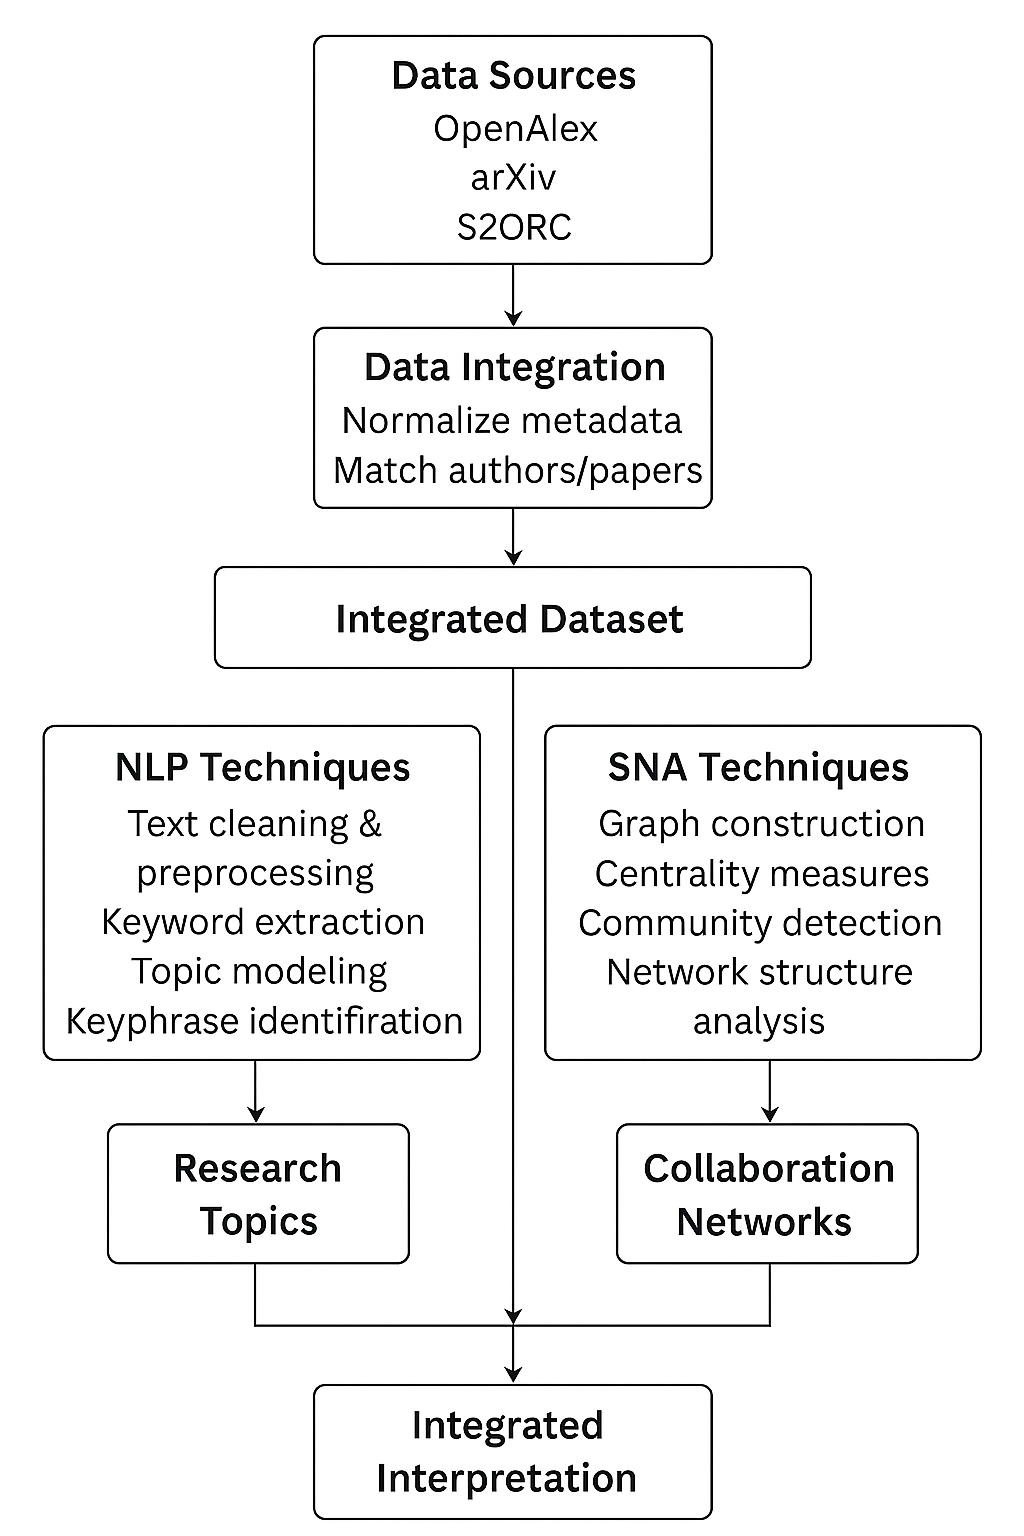

In [1]:
# Project Plan
from IPython.display import Image, display
display(Image(filename="Project Plan.png", width=500, height=300))

### OpenAlex

    OpenAlex has JSON metadata for papers, authors, institutions, concepts, and venues.
    Rich graph structure with co-authorships, citations, and affiliations.
    Free modern REST API, with a daily limit for user API calls of 100,000 requests. 
    Third-party libraries (PyAlex, diophila, OpenAlexAPI).
    There is also a complete database snapshot, updated monthly. (https://docs.openalex.org/download-all-data/openalex-snapshot)
    This snapshot has 463 million full works as of 11/12/2025, but this requires large-scale data warehouse software.
    I will use PyAlex, which wraps the API and has built-in functionality for pagination, filtering, and searches.

In [ ]:
##### Basic Query

#pip install pyalex 
# Successfully installed pyalex-0.19, the latest as of 11/13/2025.

from pyalex import Works

# Build the query: filter by publication_year >= 2020 and by concept id
results = (Works()
            .filter(publication_date="2020-01-01",  # or publication_year=2020
                    concepts={"id": "C41008148"}) # machine learning
            .get())

# Print first 5 titles
for w in results[:5]:
    print(w.get("title") or w.get("display_name"))

In [ ]:
# Fetch works related to the starting concept for a specific date

from pyalex import Works
import pandas as pd
from collections import Counter

# Query
results = (Works().filter(publication_date="2020-01-01",
                   concepts={"id": "C41008148"}) #machine learning
           .get())

# Collect unique related concepts
unique_concepts = {} 

for w in results:
    for concept in w.get("concepts", []):
        concept_id = concept["id"] #key
        concept_name = concept["display_name"] #value
        if concept_id not in unique_concepts:
            unique_concepts[concept_id] = concept_name

# Number of unique related concepts
total_unique = len(unique_concepts)
print(f"Total number of unique concepts in these filtered works: {total_unique}")


# Convert to DataFrame
concepts_df = pd.DataFrame(
    list(unique_concepts.items()),
    columns=["Concept_ID", "Concept_Name"]
)

print(concepts_df)
#concepts_df.to_csv("pyalex_concepts.csv", index=False)

#### OpenAlex Topics vs. Concepts 

    Works in OpenAlex are tagged with Topics using an automated system that takes into account the available information about the work, including title, abstract, source (journal) name, and citations. There are around 4,500 Topics. Works are assigned topics using a model that assigns scores for each topic for a work. The highest-scoring topic is that work's primary_topic.

    OpenAlex Concepts are deprecated, and as such are more inconsistent and messier. Topics are intentionally coarser but more interpretable, which makes them better suited for Topic networks, NLP labeling, and Co-occurrence graphs. Concept lists can be found here: https://openalex.org/concepts. 

---
Methodology for determining OpenAlex Topics:   
https://github.com/ourresearch/openalex-topic-classification

#### OpenAlex Entities

    The OpenAlex dataset describes scholarly entities and their connections. Together, these make a huge web (a multi-layer heterogeneous directed graph) of hundreds of millions of entities and billions of connections between them all. Below is a screenshot that shows the entity network structure.

https://docs.openalex.org/api-entities/entities-overview

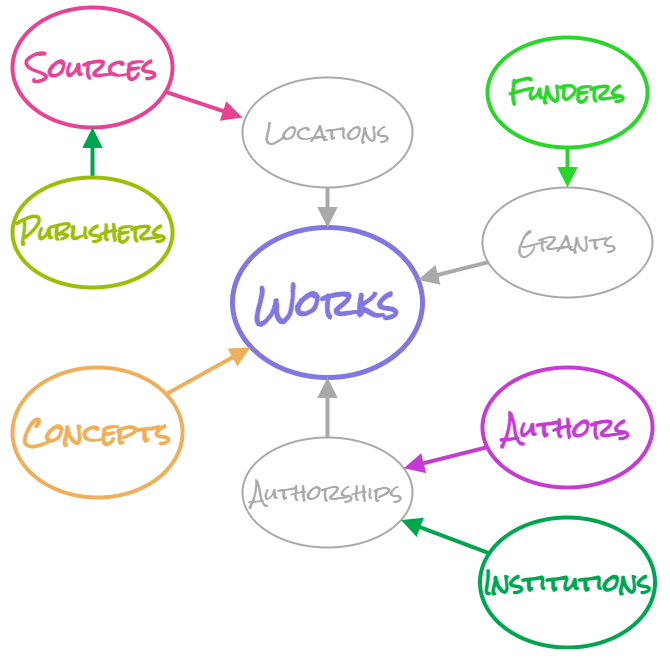

In [2]:
# OpenAlex Entity Schema: https://docs.openalex.org/api-entities/entities-overview
from IPython.display import Image, display
display(Image(filename="OpenAlex Network.png", width=500, height=300))

In [2]:
### TOPICS (Concepts)

import pyalex
from pyalex import Topics
import pandas as pd

# Build query: sort topics by number of works
query = Topics().sort(works_count="desc")

# Fetch all topics 
pager = query.paginate(method="page", per_page=100, n_max=5000)

# Loop through all pages
all_topics = []
for page in pager:
    all_topics.extend(page)

print(f"Fetched {len(all_topics)} topics")

# Convert to DataFrame using chosen columns
topics_df = pd.DataFrame(
    [
        {
            "Topic_ID": t["id"],
            "Topic_Name": t["display_name"],
            "Works_Count": t["works_count"],
            "Citations_Count": t["cited_by_count"],
            "Subfield": t["subfield"]["display_name"] if t.get("subfield") else None,
            "Field": t["field"]["display_name"] if t.get("field") else None,
            "Domain": t["domain"]["display_name"] if t.get("domain") else None,
        }
        for t in all_topics
    ]
)

print(topics_df.head())

Fetched 4516 topics
                      Topic_ID                                Topic_Name  \
0  https://openalex.org/T10346      Magnetic confinement fusion research   
1  https://openalex.org/T12157         Geochemistry and Geologic Mapping   
2  https://openalex.org/T10451  Mycorrhizal Fungi and Plant Interactions   
3  https://openalex.org/T13370   Diverse Scientific and Economic Studies   
4  https://openalex.org/T10978        Prenatal Screening and Diagnostics   

   Works_Count  Citations_Count                                   Subfield  \
0      9266563          2522186            Nuclear and High Energy Physics   
1      3954273          1646260                    Artificial Intelligence   
2      3200521          1912226                              Plant Science   
3      2889831           237816                 Economics and Econometrics   
4      1671348          1161913  Pediatrics, Perinatology and Child Health   

                                  Field             Do

#### OpenAlex Works Topic Hierarchy

    Works in OpenAlex are tagged with Topics using an automated system that checks the available information about the work, including title, abstract, source (journal) name, and citations. There are around 4,500 Topics. Topics are grouped into subfields, which are grouped into fields, which are grouped into top-level domains, shown below.  
    
https://help.openalex.org/hc/en-us/articles/24736129405719-Topics

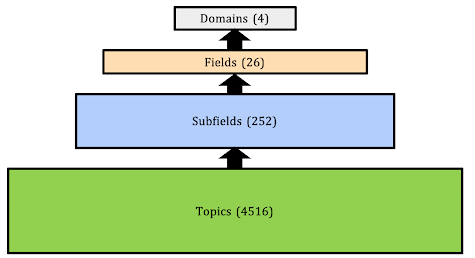

In [4]:
# OpenAlex Topic Hierarchy: https://help.openalex.org/hc/en-us/articles/24736129405719-Topics
from IPython.display import Image, display
display(Image(filename="OpenAlex layout.png", width=500, height=300))

In [5]:
# Using topics_df, I want to see actual counts for the 4 hierarchies above. Delta could be due to merged subfields, or slight API vs PyAlex mismatch

unique_domains = topics_df["Domain"].dropna().unique()
unique_fields = topics_df["Field"].dropna().unique()
unique_subfields = topics_df["Subfield"].dropna().unique()

print("Domains:", len(unique_domains))
print("Fields:", len(unique_fields))
print("Subfields:", len(unique_subfields))
print("Topics:", len(topics_df))

# Check that each topic maps to exactly one domain, field, and subfield- all 1's means no topic has multiple parent nodes, which is true here.
# topics_df.groupby("Topic_ID")[["Domain", "Field", "Subfield"]].nunique().max()

Domains: 4
Fields: 26
Subfields: 244
Topics: 4516


In [6]:
# Breakdown of Domain, Field
domains_df = (
    topics_df[["Domain"]]
    .drop_duplicates()
    .sort_values("Domain")
    .reset_index(drop=True)
)

# names of each Field, grouped by Domain
fields_df = (
    topics_df[["Domain", "Field"]]
    .drop_duplicates()
    .sort_values(["Domain", "Field"])
    .reset_index(drop=True)
)

# Grouped Print
for domain in fields_df["Domain"].unique():
    print(f"\n=== {domain} ===")
    print(fields_df[fields_df["Domain"] == domain]["Field"].tolist())


=== Health Sciences ===
['Dentistry', 'Health Professions', 'Medicine', 'Nursing', 'Veterinary']

=== Life Sciences ===
['Agricultural and Biological Sciences', 'Biochemistry, Genetics and Molecular Biology', 'Immunology and Microbiology', 'Neuroscience', 'Pharmacology, Toxicology and Pharmaceutics']

=== Physical Sciences ===
['Chemical Engineering', 'Chemistry', 'Computer Science', 'Earth and Planetary Sciences', 'Energy', 'Engineering', 'Environmental Science', 'Materials Science', 'Mathematics', 'Physics and Astronomy']

=== Social Sciences ===
['Arts and Humanities', 'Business, Management and Accounting', 'Decision Sciences', 'Economics, Econometrics and Finance', 'Psychology', 'Social Sciences']


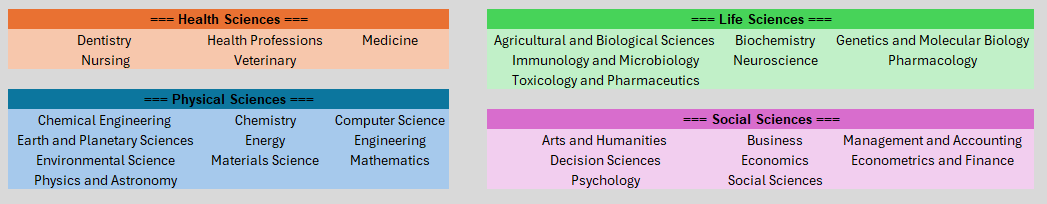

In [7]:
# The 4 Domains and associated Fields
from IPython.display import Image, display
display(Image(filename="OpenAlex Domains and Fields.png", width=1100, height=600))

#### Project Domain Scope

    Given the vast amount of data available within OpenAlex, and the inspiration for the project being an intrigue in space, I will limit the scope of my analysis to the Physical Sciences domain. The focus will be on: Chemical Engineering, Chemistry, Computer Science, Earth and Planetary Sciences, Energy, Engineering, Environmental Science, Materials Science, Mathematics, and Physics and Astronomy.

                          Field    Works_M  Citations_M  Num_Topics
5                   Engineering  39.535141   290.456460         560
9         Physics and Astronomy  24.247544   124.086524         104
2              Computer Science  21.652510   150.575591         302
6         Environmental Science  16.251385   149.751000         202
7             Materials Science   9.227390   126.172193         123
3  Earth and Planetary Sciences   7.466351    66.918329          57
1                     Chemistry   6.727007    84.205655         101
8                   Mathematics   4.180385    41.645747          82
4                        Energy   1.756860    24.637356          27
0          Chemical Engineering   0.872218    12.808487          13


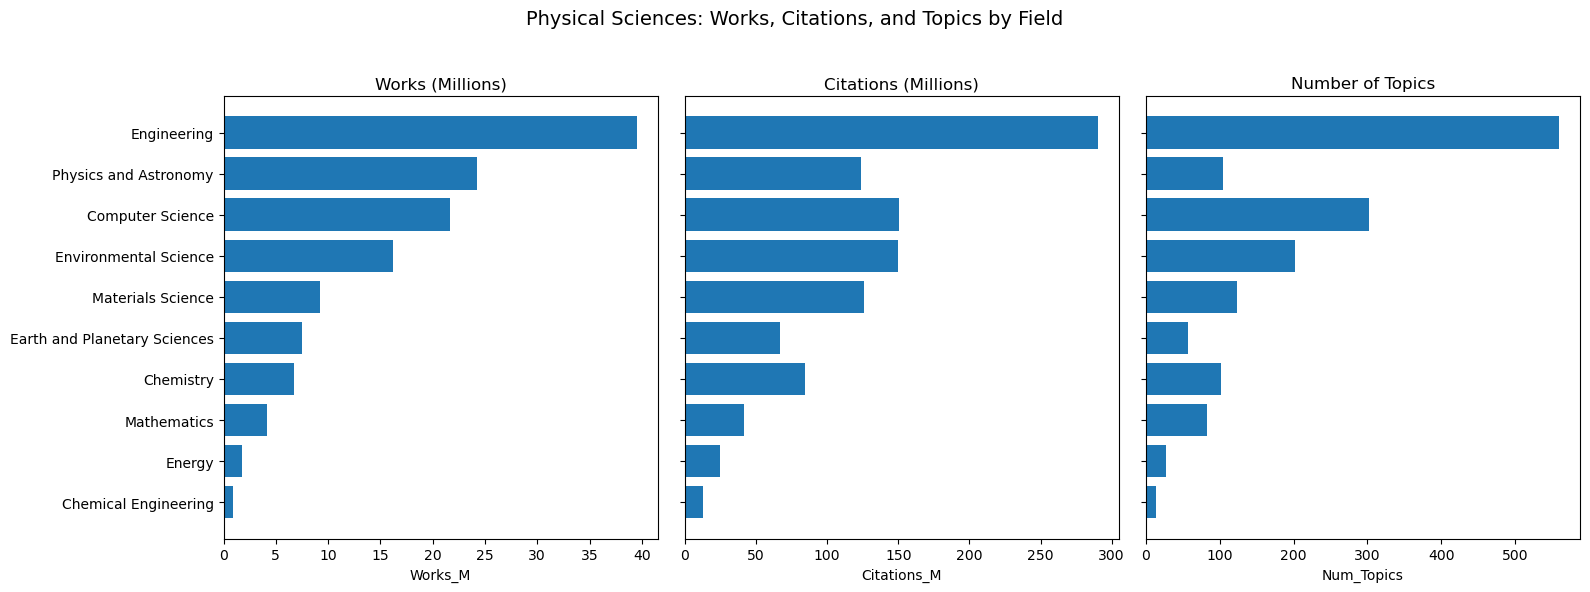

In [3]:
# Filter to Physical Sciences
physical_df = topics_df[topics_df["Domain"] == "Physical Sciences"]

# Aggregate works and citations by Field
field_metrics = (
    physical_df
    .groupby("Field", as_index=False)
    .agg(Total_Works=("Works_Count", "sum"),
         Total_Citations=("Citations_Count", "sum"),
         Num_Topics=("Topic_ID", "count"))
    .sort_values("Total_Works", ascending=False)
)

# Convert for interpretability
field_metrics["Works_M"] = field_metrics["Total_Works"] / 1000000
field_metrics["Citations_M"] = field_metrics["Total_Citations"] / 1000000

# Metrics for each Field
print(field_metrics[["Field", "Works_M", "Citations_M", "Num_Topics"]])

###################################################################
# Plot
import matplotlib.pyplot as plt

# Ensure consistent ordering
plot_df = field_metrics.sort_values("Works_M", ascending=True)

fig, axes = plt.subplots(ncols=3, figsize=(16, 6), sharey=True)

# Works
axes[0].barh(plot_df["Field"], plot_df["Works_M"])
axes[0].set_title("Works (Millions)")
axes[0].set_xlabel("Works_M")

# Citations
axes[1].barh(plot_df["Field"], plot_df["Citations_M"])
axes[1].set_title("Citations (Millions)")
axes[1].set_xlabel("Citations_M")

# Topics 
axes[2].barh(plot_df["Field"], plot_df["Num_Topics"])
axes[2].set_title("Number of Topics")
axes[2].set_xlabel("Num_Topics")

fig.suptitle("Physical Sciences: Works, Citations, and Topics by Field", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

                                 Subfield    Works_M  Citations_M  Num_Topics
66        Nuclear and High Energy Physics  12.207393    21.182324          13
32  Electrical and Electronic Engineering  10.238533    75.944353         117
6                 Artificial Intelligence   8.935975    49.992142          77
1                   Aerospace Engineering   5.602890    15.472251          44
57                    Materials Chemistry   5.233342    70.028922          69
..                                    ...        ...          ...         ...
40                        Fuel Technology   0.048785     0.109075           1
17             Chemical Health and Safety   0.046235     0.135326           1
0               Acoustics and Ultrasonics   0.024813     0.348271           1
19              Computational Mathematics   0.021040     0.272687           1
65         Nuclear Energy and Engineering   0.010804     0.026459           1

[88 rows x 4 columns]


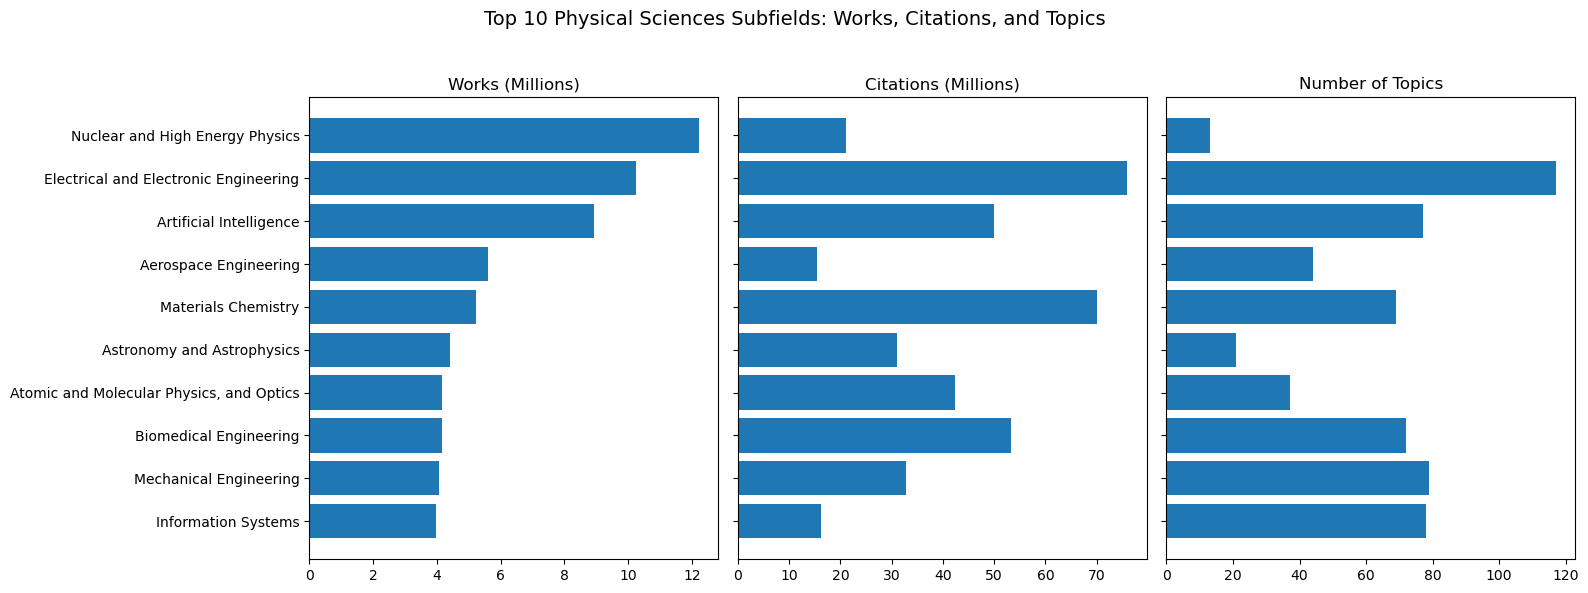

In [4]:
# Aggregate works and citations by Subfield
subfield_metrics = (
    physical_df
    .groupby("Subfield", as_index=False)
    .agg(Total_Works=("Works_Count", "sum"),
         Total_Citations=("Citations_Count", "sum"),
         Num_Topics=("Topic_ID", "count"))
    .sort_values("Total_Works", ascending=False)
)

# Convert to millions for interpretability
subfield_metrics["Works_M"] = subfield_metrics["Total_Works"] / 1000000
subfield_metrics["Citations_M"] = subfield_metrics["Total_Citations"] / 1000000

# Metrics for each Subfield
print(subfield_metrics[["Subfield", "Works_M", "Citations_M", "Num_Topics"]])

###################################################################
# Plot
import matplotlib.pyplot as plt

# Top 10 subfields by Works_M
top_subfields = (
    subfield_metrics
    .sort_values("Works_M", ascending=False)
    .head(10))

# Sort ascending 
top_subfields = top_subfields.sort_values("Works_M", ascending=True)

fig, axes = plt.subplots(ncols=3,figsize=(16, 6),sharey=True)

# Works
axes[0].barh(top_subfields["Subfield"], top_subfields["Works_M"])
axes[0].set_title("Works (Millions)")
#axes[0].set_xlabel("Works_M")

# Citations 
axes[1].barh(top_subfields["Subfield"], top_subfields["Citations_M"])
axes[1].set_title("Citations (Millions)")
#axes[1].set_xlabel("Citations_M")

# Topics 
axes[2].barh(top_subfields["Subfield"], top_subfields["Num_Topics"])
axes[2].set_title("Number of Topics")
#axes[2].set_xlabel("Num_Topics")

fig.suptitle( "Top 10 Physical Sciences Subfields: Works, Citations, and Topics", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Entity Relationships

    With my Domain and Scope updated, I want better discovery and insight into all the columns available to me for planning out SNA/NLP. I need to see how topics are linked to other entities for network analysis, and see 'siblings' which directly link topics together. I see an API access point 'works_api_url', which could link to several entities shown above. I also see the 'description' and 'keywords' work for NLP, without accessing the enormous quantity of all text corpora. I could build networks as Topic-Topic, Topic-Work, Work-Author, Author-Author (co-authorship), Author-Institution, Institution-Institution, Work-Source, and Funder-Work /Topic /Institution.
    
---
    For now, I need to inspect the structure of OpenAlex's entity schema with Works in the center, and all other entities linked to it.

In [5]:
### WORKS

from pyalex import Works
import pandas as pd
import pprint

# Fetch a small page of works
sample_works_page = next(
    Works().paginate(method="page", per_page=10, n_max=1)
)

# Flatten all columns
full_works_df = pd.json_normalize(sample_works_page)
#print("Original Works columns:", len(full_works_df.columns)) #1113

###################################################################
# Remove unwanted columns, as there are over 1000
import re

# Columns to keep
base_cols = [
    "id",
    "ids.openalex", "ids.doi", "ids.pmid",
    "title", "display_name",
    "publication_year", "publication_date",
    "language", "type",
    "cited_by_count",
    "referenced_works_count", "referenced_works",
    "related_works",
    "counts_by_year",
    "has_fulltext", "is_retracted", "is_paratext",
]

network_cols = [
    # Authorship/institutions
    "authorships",
    "institutions",
    "countries_distinct_count",
    "institutions_distinct_count",
    "corresponding_author_ids",
    "corresponding_institution_ids",
    
    # Topics/semantics
    "topics",
    "primary_topic.id",
    "primary_topic.display_name",
    "primary_topic.subfield.display_name",
    "primary_topic.field.display_name",
    "primary_topic.domain.display_name",
    "keywords",
    "concepts",
    "mesh",
    
    # Funding
    "grants",
    "funders",
    "awards",
    
    # Open access 
    "open_access.is_oa",
    "open_access.oa_status",
    "open_access.oa_url",
]

requested_cols = base_cols + network_cols

# Keep only columns that actually exist in full_works_df
keep_cols = [c for c in requested_cols if c in full_works_df.columns]

# Define patterns for columns to drop
drop_prefixes = (
    "abstract_inverted_index.",
    "primary_location.",
    "best_oa_location.",
    "has_content.",
    "biblio.",        
    "apc_list.",
    "apc_paid.",
)

cols_to_drop = [
    c for c in full_works_df.columns
    if any(c.startswith(p) for p in drop_prefixes)
]


# Option 1: Strict, minimal version, with only chosen columns (39 columns)
works_df = full_works_df[keep_cols].copy()
#print("Curated Works columns:", len(works_df.columns))

# Option 2: Drop only noisy column families (abstract_inverted_index, primary_location, etc.) (63 columns)
#works_df = full_works_df.drop(columns=cols_to_drop)


# Check first X column names
#print(works_df.columns.tolist()[:10])  

# See untruncated detail for the first entry
pprint.pprint(works_df.iloc[0].to_dict(), width=120)

{'authorships': [{'affiliations': [{'institution_ids': ['https://openalex.org/I199525922',
                                                        'https://openalex.org/I4210108322'],
                                    'raw_affiliation_string': 'National Institute for Fusion Science, National '
                                                              'Institutes of Natural Sciences'}],
                  'author': {'display_name': 'M. Shoji',
                             'id': 'https://openalex.org/A5039600762',
                             'orcid': 'https://orcid.org/0000-0003-0655-7347'},
                  'author_position': 'first',
                  'countries': ['JP'],
                  'institutions': [{'country_code': 'JP',
                                    'display_name': 'National Institute for Fusion Science',
                                    'id': 'https://openalex.org/I4210108322',
                                    'lineage': ['https://openalex.org/I1319490839',

In [8]:
### AUTHORS

from pyalex import Authors
import pandas as pd
import pprint

# Grab a small page of authors
sample_authors_page = next(
    Authors().paginate(method="page", per_page=10, n_max=1)
)

# Flatten all columns
authors_df = pd.json_normalize(sample_authors_page)

# Column count is 20
#print(len(full_authors_df.columns))
# See all column names
#print(full_authors_df.columns.tolist())

# See untruncated detail for the first entry
pprint.pprint(authors_df.iloc[0].to_dict(), width=120)

{'affiliations': [{'institution': {'country_code': 'NO',
                                   'display_name': 'University of Oslo',
                                   'id': 'https://openalex.org/I184942183',
                                   'lineage': ['https://openalex.org/I184942183'],
                                   'ror': 'https://ror.org/01xtthb56',
                                   'type': 'education'},
                   'years': [2025, 2021, 2018, 2016]}],
 'block_key': 'k larsson',
 'cited_by_count': 13,
 'counts_by_year': [{'cited_by_count': 0, 'oa_works_count': 1, 'works_count': 1, 'year': 2007},
                    {'cited_by_count': 0, 'oa_works_count': 0, 'works_count': 1, 'year': 2010},
                    {'cited_by_count': 0, 'oa_works_count': 8, 'works_count': 8, 'year': 2012},
                    {'cited_by_count': 8, 'oa_works_count': 487435, 'works_count': 487435, 'year': 2014},
                    {'cited_by_count': 0, 'oa_works_count': 141058, 'works_count': 

In [9]:
### INSTITUTIONS

from pyalex import Institutions
import pandas as pd
import pprint

# Grab a small page of institutions
sample_institutions_page = next(
    Institutions().paginate(method="page", per_page=10, n_max=10)
)

# Flatten all columns
institutions_df = pd.json_normalize(sample_institutions_page)

# Column count is 38
#print(len(full_institutions_df.columns))
# See all column names
#print(full_institutions_df.columns.tolist())

# See untruncated detail for the first entry
pprint.pprint(institutions_df.iloc[0].to_dict(), width=120)

{'associated_institutions': [{'country_code': 'JP',
                              'display_name': 'National Institutes of Natural Sciences',
                              'id': 'https://openalex.org/I199525922',
                              'relationship': 'parent',
                              'ror': 'https://ror.org/055n47h92',
                              'type': 'facility'}],
 'cited_by_count': 1475652,
 'country_code': 'JP',
 'counts_by_year': [{'cited_by_count': 31, 'oa_works_count': 18940106, 'works_count': 18940140, 'year': 2025},
                    {'cited_by_count': 584, 'oa_works_count': 10000291, 'works_count': 10000358, 'year': 2024},
                    {'cited_by_count': 993, 'oa_works_count': 185, 'works_count': 264, 'year': 2023},
                    {'cited_by_count': 1768, 'oa_works_count': 190, 'works_count': 279, 'year': 2022},
                    {'cited_by_count': 2542, 'oa_works_count': 190, 'works_count': 295, 'year': 2021},
                    {'cited_by_c

In [10]:
### TOPIC

# See all columns for a Topic
#all_topics[0].keys()

# all_topics has nested dictionaries (domain, field, subfield, ids, etc.), so it needs to be flattened.
import pandas as pd
import pprint

# Flatten all columns
topics_df = pd.json_normalize(all_topics)

# See untruncated detail for the first entry
#print("Topics:", len(topics_df))
#print("--------------")
pprint.pprint(topics_df.iloc[0].to_dict(), width=120)

{'cited_by_count': 2522186,
 'created_date': '2024-01-23T15:27:06.261858',
 'description': 'This cluster of papers covers a wide range of topics in plasma physics and fusion research, including '
                'turbulence, transport, MHD stability, edge localized modes, zonal flows, confinement, neoclassical '
                'tearing modes, energetic particles, and diagnostics. The research spans from theoretical modeling to '
                'experimental observations in various fusion devices.',
 'display_name': 'Magnetic confinement fusion research',
 'domain.display_name': 'Physical Sciences',
 'domain.id': 'https://openalex.org/domains/3',
 'field.display_name': 'Physics and Astronomy',
 'field.id': 'https://openalex.org/fields/31',
 'id': 'https://openalex.org/T10346',
 'ids.openalex': 'https://openalex.org/T10346',
 'ids.wikipedia': 'https://en.wikipedia.org/wiki/Plasma_physics',
 'keywords': ['Turbulence',
              'Tokamak',
              'Transport',
              'MH

#### Network Entities Evaluation

    I currently have 3 node types: Topics (T), Authors (A), Institutions (I), and an edge generator: Works (W), which is a node type of its own. I am less interested in the Funders, Publishers, and Source Entities, which OpenAlex explains as:

    Sources: Where works are hosted (such as journals, conferences, and repositories)
    Publishers: Companies and organizations that distribute works
    Funders: Organizations that fund research. OpenAlex indexes about 32,000 funders.

    From here, I will begin constructing my network with TAIW, a multilayer heterogeneous network with multiple node types, edge types, and directed/undirected edges, where Works are the central unifying hub. Each of my 4 node dataframes links to 'works_api_url', which allows edge tables can be made. Instead of making a singular enormous network (with data filtering needed strictly for Physical Sciences, given the sheer volume available), I will later make a separate edge list for each entity relationship.

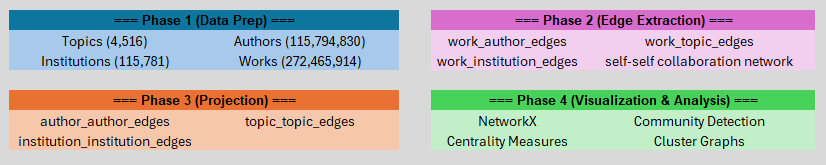

In [11]:
# SNA Setup
from IPython.display import Image, display
display(Image(filename="SNA Workflow.png", width=1100, height=600))

In [12]:
# Checking scale of available data in TAIW

from pyalex import Topics, Authors, Institutions, Works

# Total counts 
topics_total = Topics().count()
authors_total = Authors().count()
institutions_total = Institutions().count()
works_total = Works().count()

print(f"Total Topics:       {topics_total:,}")       #4,516
print(f"Total Authors:      {authors_total:,}")      #100+ million
print(f"Total Institutions: {institutions_total:,}") #115k
print(f"Total Works:        {works_total:,}")        #270+ million

# This is way too much data to work with, so I need proper filtering.

Total Topics:       4,516
Total Authors:      104,811,742
Total Institutions: 115,781
Total Works:        278,200,237


    publication_year  All_Works_M  Physical_Sciences_Works_M
189             2016    10.163751                   3.346838
190             2017    10.019150                   3.350262
191             2018    10.033532                   3.576613
192             2019    10.349796                   3.725902
193             2020    11.082866                   3.900090
194             2021    10.142149                   3.756412
195             2022     9.712780                   3.643054
196             2023    10.185004                   3.947659
197             2024     9.622721                   3.914350
198             2025    11.965528                   3.339909


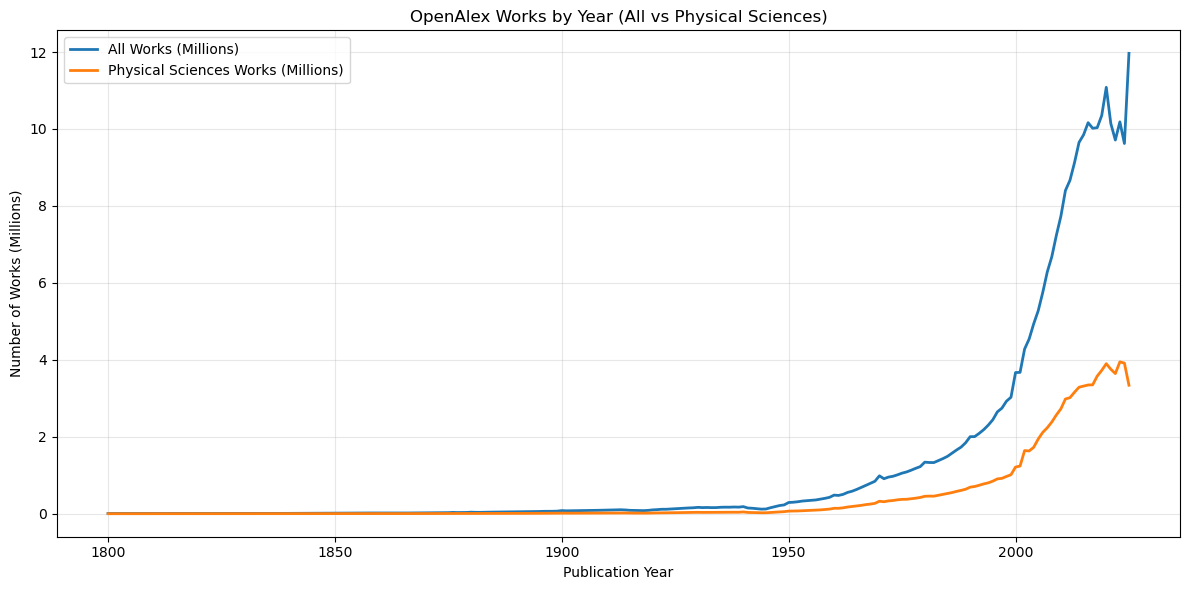

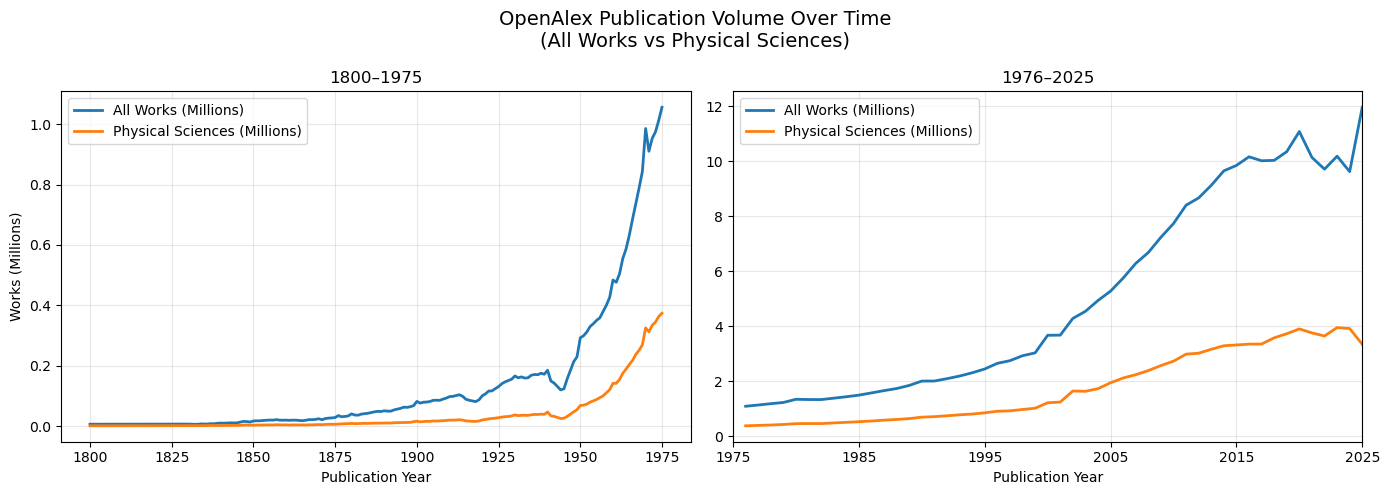

In [13]:
# Check Works by year, ranging from 1800 - 2025

from pyalex import Works
import pandas as pd
import numpy as np

# OpenAlex to group works by publication_year
grouped = (
    Works()
    .group_by("publication_year")
    .get(per_page=200)  
)

# Each element in `grouped` should look like: {"key": year, "count": n}
years_df = (
    pd.DataFrame(
        [{"publication_year": row["key"], "count": row["count"]}
         for row in grouped]
    )
    .sort_values("publication_year")
    .reset_index(drop=True)
)

#print(years_df.tail(10))

################################################################
# Works by year, for only Physical Sciences.

import requests
import pandas as pd

BASE_URL = "https://api.openalex.org/works"

# 3 = Physical Sciences domain
PHYS_DOMAIN_FILTER = "topics.domain.id:3"

params_phys = {
    "filter": PHYS_DOMAIN_FILTER,
    "group_by": "publication_year",
    "per_page": 200  
}

# Raise if bad response
resp_phys = requests.get(BASE_URL, params=params_phys)
resp_phys.raise_for_status()  
data_phys = resp_phys.json()

# Sanity check: what keys are in the response?
#print(data_phys.keys())

# Build DataFrame from grouped results
phys_years_df = (
    pd.DataFrame(data_phys["group_by"])      
    .rename(columns={"key": "publication_year", "count": "count"})
    .sort_values("publication_year"))

phys_years_df["count_M"] = phys_years_df["count"] / 1000000

#print(phys_years_df.tail(10))

################################################################
# Compare All work to Physical Science only

# Make sure column names are consistent
years_df = years_df.rename(columns={"count": "all_works"})
phys_years_df = phys_years_df.rename(columns={"count": "phys_works"})

# Merge on publication_year
compare_df = (
    years_df[["publication_year", "all_works"]]
    .merge(
        phys_years_df[["publication_year", "phys_works"]],
        on="publication_year",
        how="inner"))

# Convert for interpretability
compare_df["All_Works_M"] = compare_df["all_works"] / 1000000
compare_df["Physical_Sciences_Works_M"] = compare_df["phys_works"] / 1000000

compare_df_final = (compare_df.drop(columns=["all_works", "phys_works"]))
compare_df_final = compare_df_final.sort_values("publication_year")

# Check counts
print(compare_df_final.tail(10))

################################################################
# Plot

import matplotlib.pyplot as plt

# Ensure year is numeric
compare_df_final["publication_year"] = compare_df_final["publication_year"].astype(int)


# Create figure
plt.figure(figsize=(12, 6))

x = compare_df_final["publication_year"].to_numpy()
y_all = compare_df_final["All_Works_M"].to_numpy()
y_phys = compare_df_final["Physical_Sciences_Works_M"].to_numpy()

plt.plot(x,y_all,label="All Works (Millions)",linewidth=2)
plt.plot(x,y_phys,label="Physical Sciences Works (Millions)",linewidth=2)


plt.xlabel("Publication Year")
plt.ylabel("Number of Works (Millions)")
plt.title("OpenAlex Works by Year (All vs Physical Sciences)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

################################################################
# Split plot 
df_pre_1975 = compare_df_final[compare_df_final["publication_year"] <= 1975]
df_post_1975 = compare_df_final[compare_df_final["publication_year"] >= 1976]

# Create subplots 
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 5),
    sharey=False)


#  Left plot
x_pre = df_pre_1975["publication_year"].to_numpy()
y_pre_all = df_pre_1975["All_Works_M"].to_numpy()
y_pre_phys = df_pre_1975["Physical_Sciences_Works_M"].to_numpy()

axes[0].plot(
    x_pre,
    y_pre_all,
    label="All Works (Millions)",
    linewidth=2
)

axes[0].plot(
    x_pre,
    y_pre_phys,
    label="Physical Sciences (Millions)",
    linewidth=2
)


axes[0].set_title("1800–1975")
axes[0].set_xlabel("Publication Year")
axes[0].set_ylabel("Works (Millions)")
axes[0].grid(alpha=0.3)
axes[0].legend()



# Right plot
x_post = df_post_1975["publication_year"].to_numpy()
y_post_all = df_post_1975["All_Works_M"].to_numpy()
y_post_phys = df_post_1975["Physical_Sciences_Works_M"].to_numpy()

axes[1].plot(
    x_post,
    y_post_all,
    label="All Works (Millions)",
    linewidth=2
)

axes[1].plot(
    x_post,
    y_post_phys,
    label="Physical Sciences (Millions)",
    linewidth=2
)


# Custom ticks for right plot
custom_ticks = np.array([1975, 1985, 1995, 2005, 2015, 2025])

axes[1].set_xticks(custom_ticks)
axes[1].set_xlim(1975, 2025)
axes[1].set_title("1976–2025")
axes[1].set_xlabel("Publication Year")
axes[1].grid(alpha=0.3)
axes[1].legend()

# Title
fig.suptitle("OpenAlex Publication Volume Over Time\n(All Works vs Physical Sciences)",fontsize=14)
plt.tight_layout()
plt.show()

#### Time-Range & Computer Memory

    Given the sheer volume of 3-4 million Physical Science works annually, restricting the Domain isn't enough, so I will restrict the data to a specific time scale. I want to see just how much data my machine can handle when making this network.

In [ ]:
from pyalex import Topics, Authors, Institutions, Works
import pandas as pd
from tqdm import tqdm


################################################################
### WORKS 

PHYS_DOMAIN_ID = "https://openalex.org/domains/3"
PHYS_DOMAIN_CODE = "3"     
START_YEAR = 2020
END_YEAR = 2025
TARGET_N = 10000  
PER_PAGE = 200

# Specified query
phys_works_query = (
    Works()
    .filter(
        **{
            "topics.domain.id": PHYS_DOMAIN_CODE,              
            "from_publication_date": f"{START_YEAR}-01-01",
            "to_publication_date": f"{END_YEAR}-12-31",
        }
    )
)

# Check how many Works in selected years
print(f"Physical Sciences Works ({START_YEAR}–{END_YEAR}): {phys_works_query.count():,}")

# Pull sample
phys_works_sample = []
pager = phys_works_query.paginate(per_page=PER_PAGE)

with tqdm(total=TARGET_N, desc="Fetching Physical Sciences works") as pbar:
    for page in pager:
        phys_works_sample.extend(page)
        pbar.update(len(page))

        if len(phys_works_sample) >= TARGET_N:
            break

phys_works_sample = phys_works_sample[:TARGET_N]
phys_works_sample_df = pd.json_normalize(phys_works_sample)
print(f"\nFinal sample size: {len(phys_works_sample_df):,}") # 10k records, as defined above in TARGET_N
print("--------------------------------------------------------")

################################################################
# Measuring computer memory using phys_works_sample_df

import psutil

df_sample = phys_works_sample_df   

# Available RAM
vm = psutil.virtual_memory()
print(f"Total RAM:      {vm.total / (1024**3):.2f} GB")
print(f"Available RAM:  {vm.available / (1024**3):.2f} GB")

# How much memory does the sample take
bytes_used = df_sample.memory_usage(deep=True).sum()
print(f"\nSample size (10k works): {bytes_used / (1024**2):.2f} MB")

# Rough per-row cost
bytes_per_row = bytes_used / len(df_sample)
print(f"Approx bytes per row: {bytes_per_row:.0f}")
print("--------------------------------------------------------")

#### Works Size vs Computer Memory

    My current Works, which is filtered to the Physical Sciences Domain, from years 2020-2025, has just over 22 million records. Pulling a sample of 10k records uses 26.4 GB of memory on my computer, so I will need to aggressively trim the volume of data I am working with. Each row from Works has 2.8 MB of data, as it comes in a rich JSON format with nested dictionaries. The good news is that I don't need to store all the data, but just the columns specific to my analysis, such as work_id, publication_year, author_id, institution_id, topic_id, etc. Instead of storing full JSON data for each Work, I can pull only the desired columns and save the data, rather than keeping it cached in memory. 

In [14]:
### Minimized Works V2 ###

def extract_minimal_work(work: dict) -> dict:
    """
    Take a single OpenAlex Work JSON and return a compact dict
    """
    ################################################################
    # Basic Work-level fields
    out = {
        "work_id": work.get("id"),
        "title": work.get("display_name") or work.get("title"),
        "publication_year": work.get("publication_year"),
        "cited_by_count": work.get("cited_by_count", 0),
        "language": work.get("language"),
        "referenced_works": work.get("referenced_works", []),
    }
    
    ################################################################
    # Topics
    topics = work.get("topics", []) or []
    out["topics"] = [
        {
            "id": t.get("id"),
            "display_name": t.get("display_name"),
            "score": t.get("score"),
            "domain": (t.get("domain") or {}).get("display_name"),
            "field": (t.get("field") or {}).get("display_name"),
            "subfield": (t.get("subfield") or {}).get("display_name"),
        }
        for t in topics
    ]

    ################################################################
    # Authorships
    authorships = work.get("authorships", []) or []
    minimal_authorships = []

    for a in authorships:
        author = a.get("author") or {}
        affils = a.get("affiliations", []) or []

        minimal_affils = []
        for aff in affils:
            minimal_affils.append({
                "institution_ids": aff.get("institution_ids", []) or [],
                "raw_affiliation_string": aff.get("raw_affiliation_string"),
            })

        minimal_authorships.append({
            "author_id": author.get("id"),
            "raw_author_name": a.get("raw_author_name"),
            "countries": a.get("countries", []) or [],   
            "affiliations": minimal_affils,
        })

    out["authorships"] = minimal_authorships

    ################################################################
    return out


In [ ]:
# Testing Minimized Works being pulled

from pyalex import Works
from tqdm import tqdm
import pandas as pd

PHYS_DOMAIN_CODE = "3"
START_YEAR = 2020
END_YEAR = 2025


phys_works_query = (
    Works()
    .filter(
        **{
            "topics.domain.id": PHYS_DOMAIN_CODE,
            "from_publication_date": f"{START_YEAR}-01-01",
            "to_publication_date": f"{END_YEAR}-12-31",
        }
    )
)

# Sanity check
#phys_works_count = phys_works_query.count()
#print(f"Physical Sciences works ({START_YEAR}–{END_YEAR}): {phys_works_count:,}")

# How many works to sample
TARGET_N = 10000   
PER_PAGE = 200

rows = []
collected = 0


# Updating Progress Bar
pbar = tqdm(
    total=TARGET_N,
    desc="Fetching Minimal Physical Sciences Works",
    miniters=1000,        # update every 1000 rows
    mininterval=10,       # or every 10 seconds
    leave=True
)



for page in phys_works_query.paginate(per_page=PER_PAGE, n_max=TARGET_N):
    # 'page' is an OpenAlexResponseList (a page of works), so iterate over it
    for w in page:
        rows.append(extract_minimal_work(w)) 
        collected += 1
        pbar.update(1)

        if collected >= TARGET_N:
            break 

    if collected >= TARGET_N:
        break

pbar.close()

works_min_df = pd.DataFrame(rows)

print("Shape of Minimal Works Dataframe:", works_min_df.shape)
print("--------------------------------------------------------")
#print(works_min_df.head())
#print("\nColumns of Minimal Works:\n", works_min_df.columns.tolist())


################################################################
# Measuring computer memory for Minimal Works Dataframe

import psutil

df_sample = works_min_df  

# Available RAM
vm = psutil.virtual_memory()
print(f"Total RAM:      {vm.total / (1024**3):.2f} GB")
print(f"Available RAM:  {vm.available / (1024**3):.2f} GB")

# How much memory does the sample take
bytes_used = df_sample.memory_usage(deep=True).sum()
print(f"\nSample size ({len(df_sample):,} works): {bytes_used / (1024**2):.2f} MB")

# Rough per-row cost
bytes_per_row = bytes_used / len(df_sample)
print(f"Approx bytes per row: {bytes_per_row:,.0f}")

################################################################
# See untruncated detail for the first entry
import pprint
print("---------------------------------------------------------------------------------------------------------------------------------")
pprint.pprint(df_sample.iloc[0].to_dict(), width=120)

#### Effects of Works Memory Optimization & Planning Network Structure/Size

    By reducing what columns I pull from Works, the 10,000 Works sample shrank from 26.4 GB to 13.2 MB, and each Work shrank from 2.8 MB to 1.4 KB. This takes up 2000x less memory than the full data in a Works JSON object, allowing the network to be much larger. After restarting Jupyter to clear up some memory, I have 21 GB to work with. This could theoretically allow me to cram 10 million rows from my Minimized Works into my RAM, but I still need memory for the edge tables (Author–Work, Work–Topic, Work–Institution), node tables, Graph Processing, etc. I am now left with 2 options: Continue with my approach of using Works from 2020-2025, and pulling sample records from each, or just focusing on the 3.2 million Works for 2025. After updating my extract_minimal_work function to V2, the 10,000 Works sample rose slightly to 16 MB, with each Work being around 1.7 KB. This is a minuscule cost, but with more useful metadata for later SNA and NLP.

    
    Option 1: Stratified random sample across multiple years. This allows for temporal analysis, showing how collaboration networks and centrality metrics change over time, trends in Fields/Sub-Fields, or how Authors and Institutions enter the network. This also ensures my network is not affected by anomalies such as COVID or Policy/Funding Changes. However, this throws out a big chunk of data, and I miss out on low-frequency Authors and rare but significant Institutions. This also opens the door for over-sampling bias for high-volume entities.

    Option 2: Focus my analysis on all 3.2 million Physical Science Works in 2025. This avoids sampling bias, allows for a thorough collaboration graph, degree distributions, centrality measures, and full Author/Institution Coverage. I lose the ability for Temporal Analysis with this approach, and checking if certain Fields or collaboration structures changed over time.
    

In [ ]:
################################################################
#---- Full Pipeline for all 2025 Physical Sciences Works  -----#
################################################################

from pyalex import Works
import pandas as pd
import math
import os
import sys
# Install pyarrow and fastparquet 
# !{sys.executable} -m pip install --upgrade pyarrow fastparquet
import pyarrow
import requests
import os
import math
import glob
import re
import requests
import pandas as pd
from tqdm import tqdm

################################################################
# ---------------- CONFIG ----------------

BASE_URL = "https://api.openalex.org/works"

# Provide email for better API performance
MAILTO = "myemail@gmail.com"
# Directory for output files
OUT_DIR = r"C:\Users\Ron\DATA 620\Final Project Files V2"

PHYS_DOMAIN_CODE = "3"      # Physical Sciences
YEAR = 2025
CHUNK_SIZE = 100000        # rows per parquet file
PER_PAGE = 200             # API Works per page

# Confirm directory
os.makedirs(OUT_DIR, exist_ok=True)

################################################################
# ---------------- COUNT TOTAL WORKS ----------------

# Only Physical Sciences Works for 2025 with at least 10 citations
filter_str = (
    f"topics.domain.id:{PHYS_DOMAIN_CODE},"
    f"publication_year:{YEAR},"
    f"cited_by_count:>9"
)

params_count = {
    "filter": filter_str,
    "per_page": 1,
    "mailto": MAILTO,
}

# Prep API response
resp = requests.get(BASE_URL, params=params_count)
resp.raise_for_status()
meta = resp.json()["meta"]
total_2025_phys = meta["count"]

expected_chunks = math.ceil(total_2025_phys / CHUNK_SIZE)

print(f"Physical Sciences works in {YEAR} with >=10 citations: {total_2025_phys:,}")
print(f"Estimated chunks (@ {CHUNK_SIZE:,} rows): ~{expected_chunks}\n")

################################################################
# -------------  FIND EXISTING CHUNKS (RESUME) --------------

# Checking if a parquet file exists
pattern = re.compile(rf"works_{YEAR}_phys_10plus_chunk_(\d+)\.parquet$")
existing_files = sorted(
    glob.glob(os.path.join(OUT_DIR, f"works_{YEAR}_phys_10plus_chunk_*.parquet"))
)

existing_indices = []
for f in existing_files:
    m = pattern.search(os.path.basename(f))
    if m:
        existing_indices.append(int(m.group(1)))

if existing_indices:
    max_existing = max(existing_indices)
    start_chunk_idx = max_existing + 1
    print(f"Found existing chunks: {sorted(existing_indices)}")
    print(f"Will start writing at chunk index: {start_chunk_idx:03d}\n")
else:
    start_chunk_idx = 1
    print("No existing chunks found. Starting fresh at chunk_001.\n")

################################################################
# -------------- STREAM VIA API + WRITE CHUNKS ----------------

rows = []
current_chunk_size = 0
chunk_idx = start_chunk_idx
total_seen = 0

# Progress bar only updates when a chunk is written
pbar = tqdm(
    total=expected_chunks,
    desc=f"Writing parquet chunks for {YEAR} Physical Sciences",
    unit="chunk",
    leave=True,
)

# If resuming, advance the bar by the number of already-written chunks
if existing_indices:
    pbar.update(len(existing_indices))

# OpenAlex API cursor start
cursor = "*"  


try:
    while True:
        params = {
            "filter": filter_str,
            "per_page": PER_PAGE,
            "cursor": cursor,
            "mailto": MAILTO,
        }

        resp = requests.get(BASE_URL, params=params)
        resp.raise_for_status()
        data = resp.json()

        results = data.get("results", [])
        if not results:
            print("No more results from API.")
            break

        for work in results:
            rows.append(extract_minimal_work(work))
            current_chunk_size += 1
            total_seen += 1

            # When we hit CHUNK_SIZE, flush to a parquet file
            if current_chunk_size >= CHUNK_SIZE:
                out_path = os.path.join(
                    OUT_DIR,
                    f"works_{YEAR}_phys_10plus_chunk_{chunk_idx:03d}.parquet",
                )

                # If this chunk file already exists (resume case), skip writing it
                if os.path.exists(out_path):
                    print(
                        f"Chunk {chunk_idx:03d} already exists, "
                        f"skipping write: {out_path}"
                    )
                else:
                    pd.DataFrame(rows).to_parquet(out_path, index=False)
                    print(
                        f"  Wrote chunk {chunk_idx:03d} with "
                        f"{len(rows):,} rows -> {out_path}"
                    )

                chunk_idx += 1
                rows = []
                current_chunk_size = 0
                pbar.update(1)  # only when a chunk is written

        # Move to next cursor
        cursor = data["meta"].get("next_cursor")
        if cursor is None:
            print("Reached end of cursor pagination.")
            break

        # Safety: stop if we've seen as many works as meta.count
        if total_seen >= total_2025_phys:
            print("Seen all works indicated by meta.count; stopping.")
            break

except KeyboardInterrupt:
    print("\nInterrupted by user. Flushing remaining rows (if any)...")


################################################################
# After streaming ends or interruption, flush the remaining partial chunk
if rows:
    out_path = os.path.join(
        OUT_DIR,
        f"works_{YEAR}_phys_10plus_chunk_{chunk_idx:03d}.parquet",
    )

    if os.path.exists(out_path):
        print(
            f"Final partial chunk {chunk_idx:03d} already exists, "
            f"skipping write: {out_path}"
        )
    else:
        pd.DataFrame(rows).to_parquet(out_path, index=False)
        print(
            f"  Wrote final partial chunk {chunk_idx:03d} with "
            f"{len(rows):,} rows -> {out_path}"
        )

    pbar.update(1)

pbar.close()

################################################################
print("\nFinished streaming 2025 Physical Sciences works via API.")
print(f"Total works seen this run: {total_seen:,}")
print(f"Output directory: {OUT_DIR}")


#### Combining Work Parquet Files & Network Reduction

    With my original 32 parquet files created, I wanted to see which Works are worth keeping in my network before making edge and node tables. In the code below, I see my full 2025 Physical Works dataframe had over 3 million rows, and took up 4.7 GB. By checking the distribution of citations, I can crop out Works with very low citation counts. The original log-scaled histogram shows a large spike near 0 citations, followed by a long, thin right tail extending to ~20,000 citations. This indicates that some works are extremely influential thanks to their enormous citation metrics. The cumulative density function plots the log of citation counts on the x-axis and the percentage of Works with that number of citations on the y-axis. Put plainly, nearly 80% of Works have 10 citations or fewer.
    
    By reducing the size of the network based on citation counts, I get a sharper network structure, reduce noise and computation time, and have fewer orphan nodes when I focus on the top 10-15% of Works. After revising my query, I decided to restrict the data pulled in to works with 10 or more citations. This left me with only 1 parquet file with ~30,000 Works, instead of 32 files with 100,000 Works each. Below, I have 2 sets of plots showing the full 2025 Physical Science Works, compared to those with at least 10 citations.

In [15]:
# Check if parquet files show up

import os
import glob
import pandas as pd
import psutil

PARQUET_DIR = r"C:\Users\Ron\DATA 620\Final Project Files V2"

df_list = []

# List parquet files in directory
parquet_files = sorted(
    glob.glob(os.path.join(PARQUET_DIR, "*.parquet"))
)

print(f"Found {len(parquet_files)} parquet file(s)")
print(parquet_files)


# Loop through Works parquet files
for f in parquet_files:
    df_list.append(pd.read_parquet(f))

# Create Works dataframe
works_2025_df = pd.concat(df_list, ignore_index=True)

# Validate scale + memory
print("Rows:", len(works_2025_df)) 
print("Columns:", works_2025_df.shape[1]) 

# Memory footprint
bytes_used = works_2025_df.memory_usage(deep=True).sum()

print(f"Memory used: {bytes_used / (1024**3):.2f} GB")

vm = psutil.virtual_memory()
print(f"Available RAM after load: {vm.available / (1024**3):.2f} GB")

Found 1 parquet file(s)
['C:\\Users\\Ron\\DATA 620\\Final Project Files V2\\works_2025_phys_10plus_chunk_001.parquet']
Rows: 30191
Columns: 8
Memory used: 0.02 GB
Available RAM after load: 17.92 GB


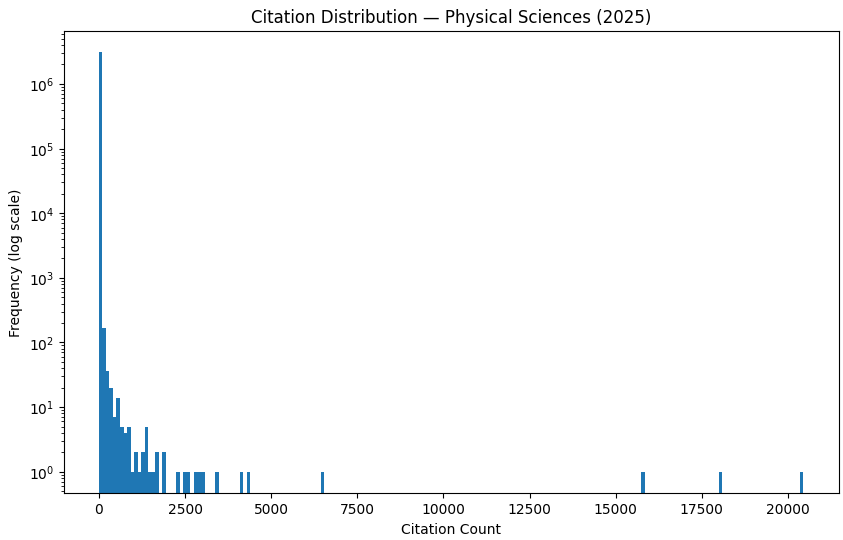

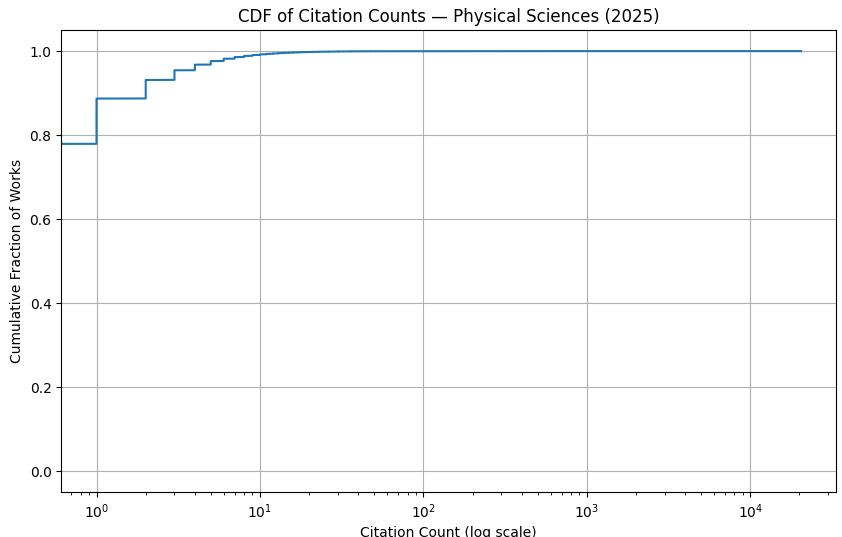

In [16]:
# Citation Distribution & CDF of 2025 Physical Science Works, without citation filtering

from IPython.display import Image, display
display(Image(filename="Citation Distribution Full.png", width=800, height=500))
display(Image(filename="Citation Distribution CDF Full.png", width=800, height=500))

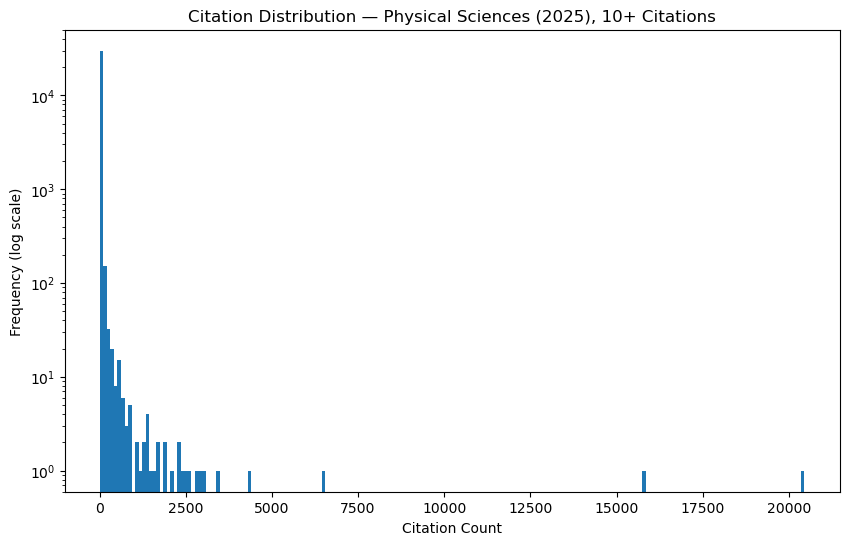

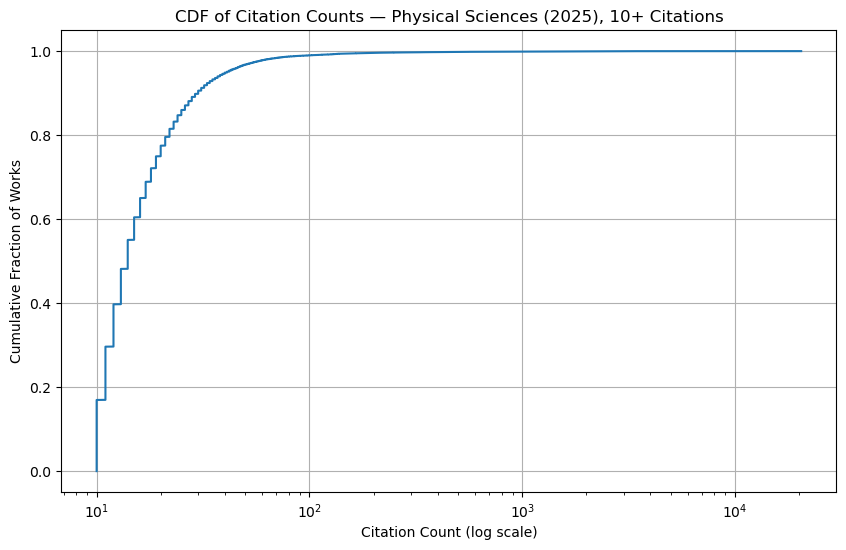

Min_Citations  Works_Count  Percentage
0              10        30191  100.000000
1              11        25075   83.054553
2              12        21244   70.365341
3              13        18199   60.279554
4              14        15655   51.853201
5              15        13571   44.950482
6              16        11947   39.571395
7              17        10562   34.983936
8              18         9394   31.115233
9              19         8420   27.889106
10             20         7563   25.050512

In [17]:
# Checking Citation Distribution, after filtering

import matplotlib.pyplot as plt
import numpy as np

works_2025_df_citations = works_2025_df["cited_by_count"]

################################################################
# Histogram (log-scaled)
plt.figure(figsize=(10,6))
plt.hist(works_2025_df_citations, bins=200)
plt.yscale("log")
plt.xlabel("Citation Count")
plt.ylabel("Frequency (log scale)")
plt.title("Citation Distribution — Physical Sciences (2025), 10+ Citations")
plt.show()


################################################################
# Cumulative distribution
sorted_cites = np.sort(works_2025_df_citations)

cdf = np.arange(1, len(sorted_cites) + 1) / len(sorted_cites)

plt.figure(figsize=(10,6))
plt.plot(sorted_cites, cdf)
plt.xscale("log")
plt.xlabel("Citation Count (log scale)")
plt.ylabel("Cumulative Fraction of Works")
plt.title("CDF of Citation Counts — Physical Sciences (2025), 10+ Citations")
plt.grid(True)
plt.show()

################################################################
# Citation Threshold counts

thresholds = [10,11,12,13,14,15,16,17,18,19,20]
counts = []
total_works = len(works_2025_df)

for t in thresholds:
    n = (works_2025_df["cited_by_count"] >= t).sum()
    counts.append({
        "Min_Citations": t,
        "Works_Count": n,
        "Percentage": (n * 100)/ total_works
    })

citation_threshold_df = pd.DataFrame(counts)
citation_threshold_df

In [18]:
# Build Node and Edge tables for WTAI

import numpy as np
import pandas as pd
from collections import Counter

################################################################################################################################
# WORKS node table
work_nodes = (works_2025_df[["work_id", "title", "publication_year", "language", "cited_by_count"]]
    .drop_duplicates(subset=["work_id"])
    .reset_index(drop=True))

print("work_nodes Columns:", work_nodes.columns.tolist())
#print("work_nodes Length:", len(work_nodes))

################################################################################################################################
# WORKS-AUTHORS edge table

work_author_edges = works_2025_df[["work_id", "authorships"]].copy()

# Each row may have a list of authorships,  explode to one row per authorship
work_author_edges = work_author_edges.explode("authorships").reset_index(drop=True)

# helper: extract institution_ids from one authorship dict
def get_institution_ids(a):
    if not isinstance(a, dict):
        return []

    affs = a.get("affiliations", None)
    if affs is None:
        return []

    # If affs is a numpy array or other non-list, try to convert to a list
    if not isinstance(affs, (list, tuple)):
        try:
            affs = list(affs)
        except TypeError:
            return []

    inst_ids = []
    for aff in affs:
        if not isinstance(aff, dict):
            continue
        ids = aff.get("institution_ids", None)
        if ids is None:
            continue

        # ids might be a list, tuple, numpy array, or scalar
        if isinstance(ids, (list, tuple, np.ndarray)):
            inst_ids.extend(list(ids))
        else:
            inst_ids.append(ids)

    # Deduplicate while preserving order
    return list(dict.fromkeys(inst_ids))


# helper: extract raw affiliation strings from one authorship dict
def get_raw_affiliations(a):
    if not isinstance(a, dict):
        return []

    affs = a.get("affiliations", None)
    if affs is None:
        return []

    if not isinstance(affs, (list, tuple)):
        try:
            affs = list(affs)
        except TypeError:
            return []

    raw_list = []
    for aff in affs:
        if not isinstance(aff, dict):
            continue
        s = aff.get("raw_affiliation_string", None)
        if s:
            raw_list.append(s)

    return list(dict.fromkeys(raw_list))


# Recompute these two columns 
work_author_edges["author_institution_ids"] = work_author_edges["authorships"].apply(get_institution_ids)
work_author_edges["author_raw_affiliations"] = work_author_edges["authorships"].apply(get_raw_affiliations)

print("work_author_edges Columns:", work_author_edges.columns.tolist())
#print("work_author_edges Length:", len(work_author_edges))

################################################################################################################################
# AUTHORS node table

# Helper functions to pull author-level info out of each authorship dict
def get_author_id(a):
    if isinstance(a, dict):
        return a.get("author_id")
    return None

def get_raw_author_name(a):
    if isinstance(a, dict):
        return a.get("raw_author_name")
    return None

# Apply to existing work_author_edges
work_author_edges["author_id"] = work_author_edges["authorships"].apply(get_author_id)
work_author_edges["raw_author_name"] = work_author_edges["authorships"].apply(get_raw_author_name)


# Build the Author node table: one row per unique author_id
author_nodes = (work_author_edges
                .dropna(subset=["author_id"])        # keep rows with real OpenAlex author IDs
                .groupby("author_id", as_index=False)
                .agg({"raw_author_name": "first",      # canonical name
                "author_institution_ids": "sum", # concatenate lists
                "author_raw_affiliations": "sum"}))

# Deduplicate list columns at author level
author_nodes["author_institution_ids"] = author_nodes["author_institution_ids"].apply(
    lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else []
)
author_nodes["author_raw_affiliations"] = author_nodes["author_raw_affiliations"].apply(
    lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else []
)

print("author_nodes Columns:", author_nodes.columns.tolist())
#print("author_nodes Length:", len(author_nodes))

################################################################################################################################
# WORKS-TOPICS edge table 

# Safety check: make sure we have the columns we expect
#print("works_2025_df columns:", works_2025_df.columns.tolist())

import pandas as pd

def extract_topic_rows(work_row):
    """
    From a single work row, return a list of dicts: one row per (work, topic).

    Expected to handle:
      - topics as a list of dicts
      - topics as numpy arrays of dicts
      - topics as None / NaN / weird values
      - domain/field/subfield as dicts OR strings
    """
    work_id = work_row.get("work_id")
    topics = work_row.get("topics")

    # Handle None / NaN safely
    if topics is None or (isinstance(topics, float) and pd.isna(topics)):
        return []

    # Convert numpy array -> list, if needed
    if hasattr(topics, "tolist"):
        topics = topics.tolist()

    # If it's not a list by now, bail out
    if not isinstance(topics, list):
        return []

    rows = []

    for t in topics:
        if not isinstance(t, dict):
            continue

        # Domain can be dict or already a string
        domain = t.get("domain")
        if isinstance(domain, dict):
            domain_name = domain.get("display_name")
        else:
            domain_name = domain  # might be string or None

        # Field can be dict or string
        field = t.get("field")
        if isinstance(field, dict):
            field_name = field.get("display_name")
        else:
            field_name = field

        # Subfield can be dict or string
        subfield = t.get("subfield")
        if isinstance(subfield, dict):
            subfield_name = subfield.get("display_name")
        else:
            subfield_name = subfield

        rows.append(
            {
                "work_id": work_id,
                "topic_id": t.get("id"),
                "topic_name": t.get("display_name"),
                "topic_score": t.get("score"),
                "topic_domain": domain_name,
                "topic_field": field_name,
                "topic_subfield": subfield_name,
            }
        )

    return rows


# Build long edge list: one row per (work, topic)
topic_edge_rows = []
for _, row in works_2025_df[["work_id", "topics"]].iterrows():
    topic_edge_rows.extend(extract_topic_rows(row))

work_topic_edges = pd.DataFrame(topic_edge_rows)

# Drop any rows where topic_id is missing 
work_topic_edges = work_topic_edges.dropna(subset=["topic_id"]).reset_index(drop=True)

#print("\nWork–Topic edge table (work_topic_edges):")
#print("  Shape:", work_topic_edges.shape)
#print(work_topic_edges.head())
print("work_topic_edges Columns:", work_topic_edges.columns.tolist())
#print("work_topic_edges Length:", len(work_topic_edges))

################################################################################################################################
# TOPICS node table

topic_nodes = (
    work_topic_edges
    .drop_duplicates(subset=["topic_id"])
    [["topic_id", "topic_name", "topic_domain", "topic_field", "topic_subfield"]]
    .reset_index(drop=True)
)

#print("\nTopic node table (topic_nodes):")
#print("  Shape:", topic_nodes.shape)
#print(topic_nodes.head())
print("topic_nodes Columns:", topic_nodes.columns.tolist())
#print("topic_nodes Length:", len(topic_nodes))

################################################################################################################################
# WORKS-INSTITUTIONS edge table

# Start from work_author_edges: ['work_id', 'authorships', 'author_institution_ids', 'author_raw_affiliations','author_id', 'raw_author_name']
# Keep only the columns needed for Work–Institution 
work_institution_edges = work_author_edges[["work_id", "author_institution_ids"]].copy()

# Check that institution-id column is always a list (or empty list)
def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, (np.ndarray, tuple)):
        return list(x)
    if pd.isna(x):
        return []
    # If it's a scalar string or something else, wrap in list
    return [x]

work_institution_edges["author_institution_ids"] = work_institution_edges["author_institution_ids"].apply(ensure_list)

# Explode so each row is (work_id, single institution_id)
work_institution_edges = (
    work_institution_edges
    .explode("author_institution_ids")
    .rename(columns={"author_institution_ids": "institution_id"})
    .reset_index(drop=True)
)

# Drop rows with missing institution_id
work_institution_edges = work_institution_edges.dropna(subset=["institution_id"])

# Remove duplicate (work_id, institution_id) pairs
work_institution_edges = work_institution_edges.drop_duplicates(
    subset=["work_id", "institution_id"]
).reset_index(drop=True)

print("work_institution_edges Columns:", work_institution_edges.columns.tolist())
#print("work_institution_edges Length:", len(work_institution_edges))


################################################################################################################################
# INSTITUTIONS node table

# author_nodes: ['author_id', 'raw_author_name', 'author_institution_ids', 'author_raw_affiliations']

# 1Explode institution IDs so each row is (author, single institution_id)
inst_edges = (author_nodes[["author_id", "author_institution_ids", "author_raw_affiliations"]]
            .explode("author_institution_ids")
            .rename(columns={"author_institution_ids": "institution_id"})
            .reset_index(drop=True))

# Drop rows with missing institution_id
inst_edges = inst_edges.dropna(subset=["institution_id"])

# Ensure institution_id is always treated as a string
inst_edges["institution_id"] = inst_edges["institution_id"].astype(str)

# Now explode affiliation strings as well: (author, institution_id, single affiliation string)
inst_edges = inst_edges.explode("author_raw_affiliations").reset_index(drop=True)

# Some rows may have NaN affiliation strings: keep them but handle carefully
# For building institution names, only use the non-null strings
def collect_affiliations(series):
    # series is all affiliation strings seen for this institution_id
    # Keep only actual strings
    vals = [s for s in series if isinstance(s, str)]
    return vals

inst_group = (
    inst_edges
    .groupby("institution_id", as_index=False)
    .agg({"author_raw_affiliations": collect_affiliations})
)

# Pick a "canonical" institution name from the affiliation strings:
#  heuristic approach: most frequent full affiliation string
def pick_institution_name(aff_list):
    if not aff_list:
        return None
    counts = Counter(aff_list)
    # most_common returns list of (item, count); take the most frequent string
    return counts.most_common(1)[0][0]

inst_group["institution_name"] = inst_group["author_raw_affiliations"].apply(pick_institution_name)

# Build the institution_nodes table
institution_nodes = inst_group[["institution_id", "institution_name", "author_raw_affiliations"]].copy()

print("institution_nodes Columns:", institution_nodes.columns.tolist())
#print("institution_nodes Length:", len(institution_nodes))

work_nodes Columns: ['work_id', 'title', 'publication_year', 'language', 'cited_by_count']
work_author_edges Columns: ['work_id', 'authorships', 'author_institution_ids', 'author_raw_affiliations']
author_nodes Columns: ['author_id', 'raw_author_name', 'author_institution_ids', 'author_raw_affiliations']
work_topic_edges Columns: ['work_id', 'topic_id', 'topic_name', 'topic_score', 'topic_domain', 'topic_field', 'topic_subfield']
topic_nodes Columns: ['topic_id', 'topic_name', 'topic_domain', 'topic_field', 'topic_subfield']
work_institution_edges Columns: ['work_id', 'institution_id']
institution_nodes Columns: ['institution_id', 'institution_name', 'author_raw_affiliations']


Node table sizes:
  work_nodes: 30,191
  author_nodes: 171,732
  topic_nodes: 2,783
  institution_nodes: 10,106

Edge table sizes:
  work_author_edges: 221,199
  work_topic_edges: 87,189
  work_institution_edges: 63,040


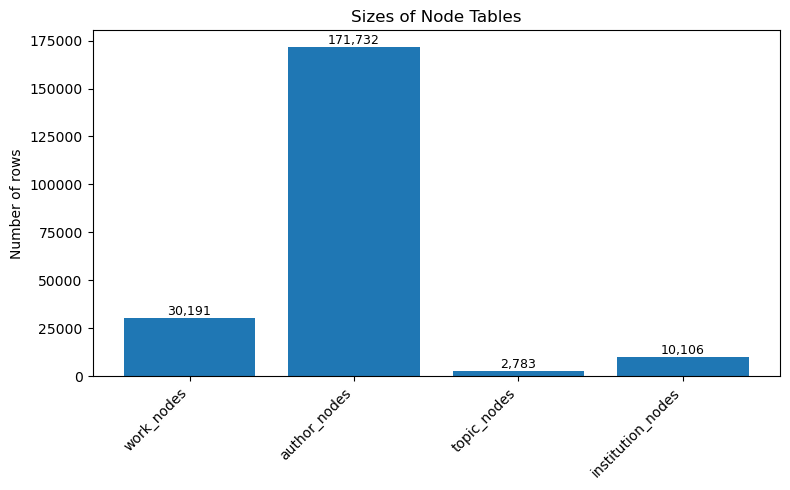

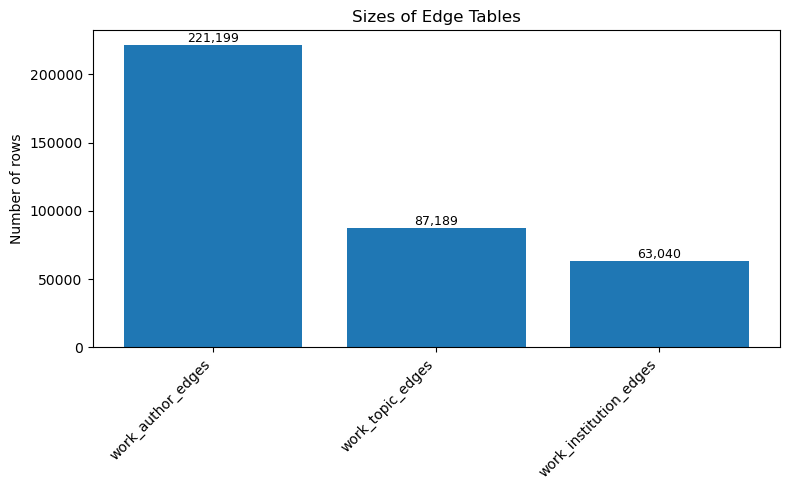

In [19]:
import matplotlib.pyplot as plt

################################################################################################################################
# Collect sizes for NODE tables
node_table_names = ["work_nodes", "author_nodes", "topic_nodes", "institution_nodes"]
node_labels = []
node_sizes = []

for name in node_table_names:
    if name in globals():
        tbl = globals()[name]
        node_labels.append(name)
        node_sizes.append(len(tbl))

print("Node table sizes:")
for label, size in zip(node_labels, node_sizes):
    print(f"  {label}: {size:,}")

################################################################################################################################
# Collect sizes for EDGE tables
edge_table_names = ["work_author_edges", "work_topic_edges", "work_institution_edges"]
edge_labels = []
edge_sizes = []

for name in edge_table_names:
    if name in globals():
        tbl = globals()[name]
        edge_labels.append(name)
        edge_sizes.append(len(tbl))

print("\nEdge table sizes:")
for label, size in zip(edge_labels, edge_sizes):
    print(f"  {label}: {size:,}")

################################################################################################################################
# Plot 1: Node tables 
plt.figure(figsize=(8, 5))
x_pos = range(len(node_labels))
plt.bar(x_pos, node_sizes)
plt.xticks(x_pos, node_labels, rotation=45, ha="right")
plt.ylabel("Number of rows")
plt.title("Sizes of Node Tables")
for x, y in zip(x_pos, node_sizes):
    plt.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

################################################################################################################################
# Plot 2: Edge tables 
plt.figure(figsize=(8, 5))
x_pos = range(len(edge_labels))
plt.bar(x_pos, edge_sizes)
plt.xticks(x_pos, edge_labels, rotation=45, ha="right")
plt.ylabel("Number of rows")
plt.title("Sizes of Edge Tables")
for x, y in zip(x_pos, edge_sizes):
    plt.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


#### Current Network Status

    I now have the following to build my network
    
    - Works node table (work_nodes): 30k Works
    - Authors node table (author_nodes): 171k Authors
    - Topics node table (topic_nodes): 2.8k Topics
    - Institutions node table (institution_nodes ): 10k Institutions
      
    - Works-Authors edge table (work_author_edges): 221k pairs
    - Works-Topics edge table (work_topic_edges): 87k pairs
    - Works-Institution edge table (work_institution_edges): 63k pairs

In [21]:
# Building network

import networkx as nx
import numpy as np
import pandas as pd

################################################################################################################################
# Build Work–Author bipartite graph

G_wait = nx.Graph()

# Add WORK nodes
for _, row in work_nodes.iterrows():
    G_wait.add_node(
        row["work_id"],
        node_type="work",
        title=row.get("title"),
        publication_year=row.get("publication_year"),
        language=row.get("language"),
        cited_by_count=row.get("cited_by_count"),
    )

# Add AUTHOR nodes
for _, row in author_nodes.iterrows():
    G_wait.add_node(
        row["author_id"],
        node_type="author",
        raw_author_name=row.get("raw_author_name"),
        author_institution_ids=row.get("author_institution_ids"),
        author_raw_affiliations=row.get("author_raw_affiliations"),
    )

#  Add EDGES: Work <-> Author
edge_count = 0
for _, row in work_author_edges.iterrows():
    w = row.get("work_id")
    a = row.get("author_id")

    if pd.isna(a) or pd.isna(w):
        continue

    # Only add edge if both nodes exist in the graph
    if w in G_wait and a in G_wait:
        G_wait.add_edge(w, a)
        edge_count += 1

################################################################################################################################
# Add INSTITUTIONS to the Work–Author network 

# Author–Institution edge table
rows = []
for _, row in author_nodes.iterrows():
    a_id = row["author_id"]
    inst_ids = row.get("author_institution_ids", [])

    if not isinstance(inst_ids, list):
        continue

    for inst_id in inst_ids:
        if pd.isna(inst_id):
            continue
        rows.append({"author_id": a_id, "institution_id": inst_id})

author_institution_edges = (
    pd.DataFrame(rows)
    .drop_duplicates()
    .reset_index(drop=True))


# Institution node table (unique institution IDs in those edges)
institution_nodes = (
    author_institution_edges[["institution_id"]]
    .drop_duplicates()
    .reset_index(drop=True))


# Add institution nodes to existing network
for _, row in institution_nodes.iterrows():
    inst_id = row["institution_id"]
    if inst_id not in G_wait:
        G_wait.add_node(inst_id, node_type="institution")

# Tag existing edges as work–author where appropriate
node_types = nx.get_node_attributes(G_wait, "node_type")
for u, v in G_wait.edges():
    t_u = node_types.get(u)
    t_v = node_types.get(v)
    if {t_u, t_v} == {"work", "author"}:
        G_wait.edges[u, v]["edge_type"] = "work-author"

# Add Author–Institution edges
added_ai_edges = 0
for _, row in author_institution_edges.iterrows():
    a = row["author_id"]
    inst = row["institution_id"]

    if a in G_wait and inst in G_wait:
        if G_wait.has_edge(a, inst):
            # If an edge already exists for some reason, merge types
            existing_type = G_wait.edges[a, inst].get("edge_type")
            if existing_type and "author-institution" not in str(existing_type):
                G_wait.edges[a, inst]["edge_type"] = f"{existing_type},author-institution"
        else:
            G_wait.add_edge(a, inst, edge_type="author-institution")
            added_ai_edges += 1

################################################################################################################################
# Add TOPICS to the tri-partite network G

# Add Topic nodes
for _, row in topic_nodes.iterrows():
    t_id = row["topic_id"]
    t_name = row.get("topic_name")
    t_domain = row.get("topic_domain")
    t_field = row.get("topic_field")
    t_subfield = row.get("topic_subfield")

    if t_id not in G_wait:
        G_wait.add_node(
            t_id,
            node_type="topic",
            topic_name=t_name,
            topic_domain=t_domain,
            topic_field=t_field,
            topic_subfield=t_subfield,
        )
    else:
        # If node already exists, make sure type is set
        if "node_type" not in G_wait.nodes[t_id]:
            G_wait.nodes[t_id]["node_type"] = "topic"

# Add Work–Topic edges
added_wt_edges = 0
for _, row in work_topic_edges.iterrows():
    w_id = row["work_id"]
    t_id = row["topic_id"]

    # Make sure both endpoints exist
    if (w_id in G_wait) and (t_id in G_wait):
        if G_wait.has_edge(w_id, t_id):
            # Merge edge types if something is already there
            existing_type = G_wait.edges[w_id, t_id].get("edge_type")
            if existing_type and "work-topic" not in str(existing_type):
                G_wait.edges[w_id, t_id]["edge_type"] = f"{existing_type},work-topic"
        else:
            G_wait.add_edge(
                w_id,
                t_id,
                edge_type="work-topic",
                topic_score=row.get("topic_score"),
            )
            added_wt_edges += 1

################################################################################################################################
# Updated summary

node_types = nx.get_node_attributes(G_wait, "node_type")

num_works = sum(1 for t in node_types.values() if t == "work")
num_authors = sum(1 for t in node_types.values() if t == "author")
num_insts = sum(1 for t in node_types.values() if t == "institution")
num_topics = sum(1 for t in node_types.values() if t == "topic")

total_nodes = G_wait.number_of_nodes()
total_edges = G_wait.number_of_edges()

edge_types = nx.get_edge_attributes(G_wait, "edge_type")
num_work_author_edges = sum(1 for et in edge_types.values() if "work-author" in str(et))
num_author_inst_edges = sum(1 for et in edge_types.values() if "author-institution" in str(et))
num_work_topic_edges = sum(1 for et in edge_types.values() if "work-topic" in str(et))

print("Quadri-partite graph (Works–Authors–Institutions–Topics):")
print(f"  Total nodes:                 {total_nodes:,}")
print(f"    Work nodes:                {num_works:,}")
print(f"    Author nodes:              {num_authors:,}")
print(f"    Institution nodes:         {num_insts:,}")
print(f"    Topic nodes:               {num_topics:,}")
print(f"  Total edges:                 {total_edges:,}")
print(f"    Work–Author edges:         {num_work_author_edges:,}")
print(f"    Author–Institution edges:  {num_author_inst_edges:,}")
print(f"    Work–Topic edges:          {num_work_topic_edges:,}")
print(f"  Density:                     {nx.density(G_wait):.6f}")

Quadri-partite graph (Works–Authors–Institutions–Topics):
  Total nodes:                 214,812
    Work nodes:                30,191
    Author nodes:              171,732
    Institution nodes:         10,106
    Topic nodes:               2,783
  Total edges:                 454,272
    Work–Author edges:         220,472
    Author–Institution edges:  146,611
    Work–Topic edges:          87,189
  Density:                     0.000020


In [22]:
# Densest core via core-number on the full quadri-partite network

import networkx as nx
from collections import Counter


# Compute core numbers for all nodes
core_nums = nx.core_number(G_wait)

# Identify the maximum core value and nodes in that core
max_core = max(core_nums.values())
densest_nodes = [n for n, c in core_nums.items() if c == max_core]

#  Induce the densest core subgraph
G_core = G_wait.subgraph(densest_nodes).copy()

################################################################################################################################
# Basic summary of the densest core

num_nodes_core = G_core.number_of_nodes()
num_edges_core = G_core.number_of_edges()
density_core = nx.density(G_core)

print("=== Densest Core (Max k-core) Summary ===")
print(f"Max core number (k):      {max_core}")
print(f"Core nodes:               {num_nodes_core}")
print(f"Core edges:               {num_edges_core}")
print(f"Core density:             {density_core:.6f}")

################################################################################################################################
# Node-type breakdown inside the core

# Helper to safely read node_type (fallback to 'type' if needed)
def get_node_type(node):
    data = G_core.nodes[node]
    return data.get("node_type") or data.get("type") or "unknown"

core_types = [get_node_type(n) for n in G_core.nodes()]
type_counts = Counter(core_types)

print("\nNode-type breakdown in densest core:")
print(f"  Work nodes:         {type_counts.get('work', 0)}")
print(f"  Author nodes:       {type_counts.get('author', 0)}")
print(f"  Institution nodes:  {type_counts.get('institution', 0)}")
print(f"  Topic nodes:        {type_counts.get('topic', 0)}")
print(f"  Unknown type nodes: {type_counts.get('unknown', 0)}")

=== Densest Core (Max k-core) Summary ===
Max core number (k):      16
Core nodes:               75
Core edges:               866
Core density:             0.312072

Node-type breakdown in densest core:
  Work nodes:         35
  Author nodes:       38
  Institution nodes:  0
  Topic nodes:        2
  Unknown type nodes: 0


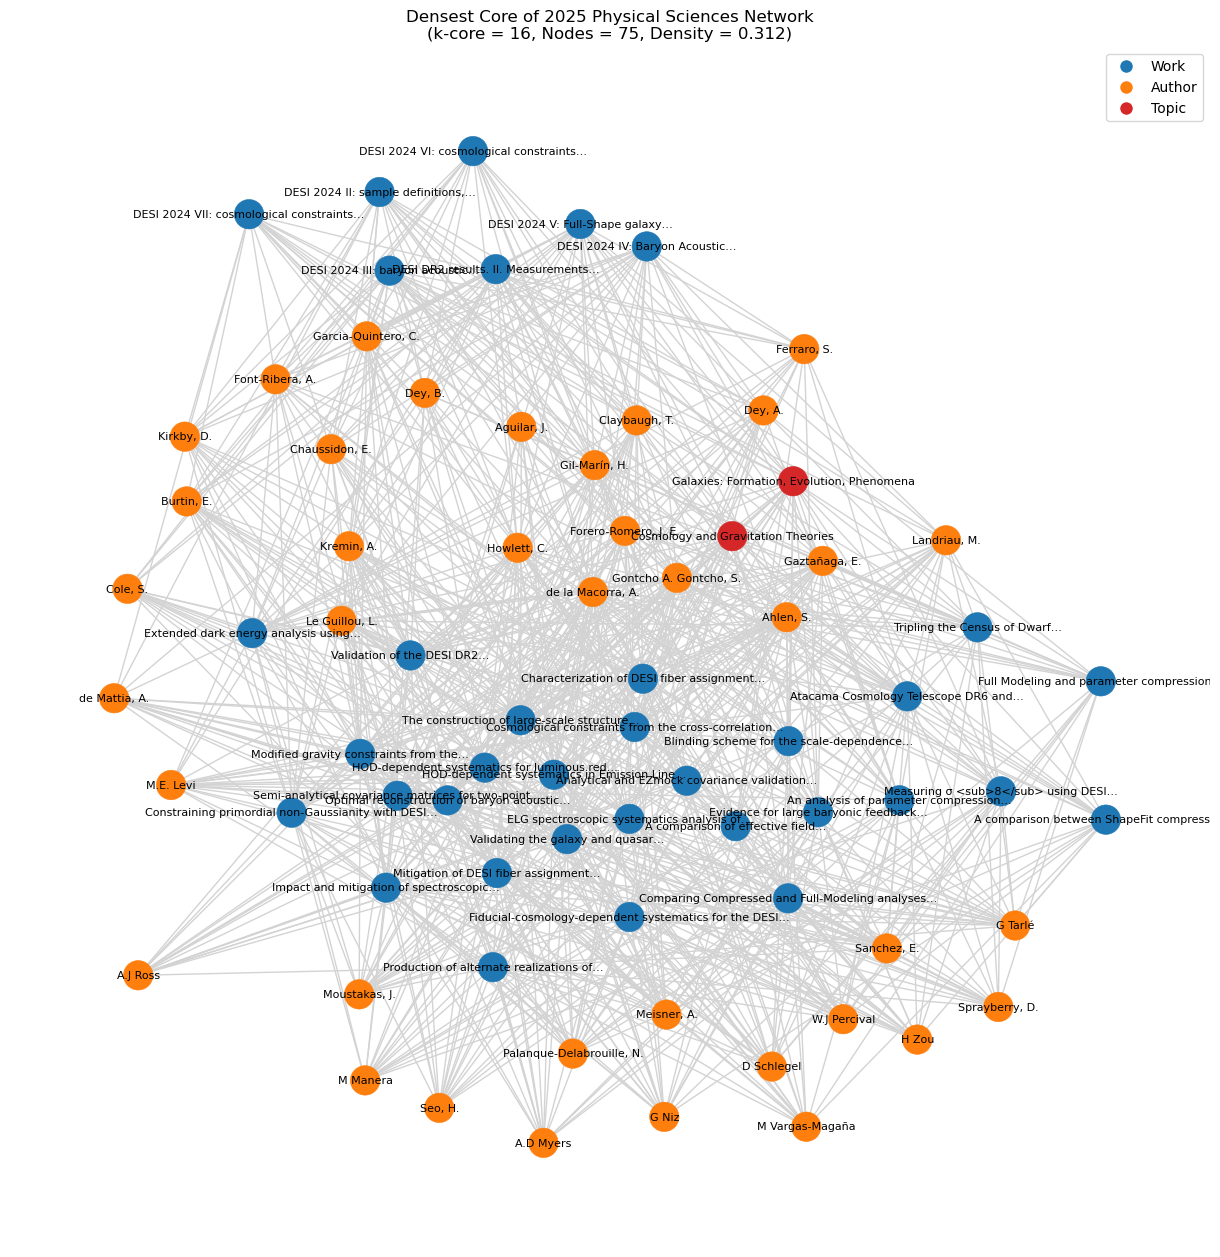

In [23]:
# Plot the core
import matplotlib.pyplot as plt
import networkx as nx
import textwrap

# Helper: choose a readable label per node 
def node_label(n, attrs, max_words=5):
    ntype = attrs.get("node_type")

    if ntype == "work":
        title = attrs.get("title", "")
        words = title.split()
        if len(words) > max_words:
            return " ".join(words[:max_words]) + "…"
        return title

    if ntype == "author":
        return attrs.get("raw_author_name", "")

    if ntype == "topic":
        return attrs.get("topic_name", "")

    if ntype == "institution":
        return attrs.get("institution_name", n.split("/")[-1])

    return n.split("/")[-1]


# Color map by node type
color_map = {
    "work": "#1f77b4",        # blue
    "author": "#ff7f0e",      # orange
    "institution": "#2ca02c", # green
    "topic": "#d62728",       # red
}

node_colors = []
labels = {}

for n, attrs in G_core.nodes(data=True):
    ntype = attrs.get("node_type", "unknown")
    node_colors.append(color_map.get(ntype, "#7f7f7f"))
    labels[n] = node_label(n, attrs)


# Layout
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_core, seed=42, k=0.6)

nx.draw(
    G_core,
    pos,
    node_color=node_colors,
    node_size=450,
    edge_color="lightgray",
    linewidths=0.4,
    with_labels=False,
)

nx.draw_networkx_labels(
    G_core,
    pos,
    labels=labels,
    font_size=8,
    verticalalignment="center"
)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Work',
               markerfacecolor=color_map["work"], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Author',
               markerfacecolor=color_map["author"], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Topic',
               markerfacecolor=color_map["topic"], markersize=10),
]

plt.legend(handles=legend_elements, loc="upper right")

plt.title(
    f"Densest Core of 2025 Physical Sciences Network\n"
    f"(k-core = {max_core}, Nodes = {G_core.number_of_nodes()}, "
    f"Density = {nx.density(G_core):.3f})",
    fontsize=12)

plt.show()

#### Overall Core Centrality Metrics 

    With my WAIT network made, I used Network X's k-core approach to find my core. A k-core is a maximal subgraph where every node has degree ≥ k within that subgraph (after iterative pruning), which is better than degree-based trimming, which doesn't iterate or re-check degrees after removing nodes. My G_wait, once trimmed to its G_core, is left with 75 nodes with 31% density, showing the most significant nodes. I will go more granular by making co-collaboration networks across my Works, Authors, Institutions, and Topics, and get centrality metrics for each one. This will show the most prominent node in each of the 4 categories. 

Building Work–Work projection (shared authors)...
Work–Work graph: 30191 nodes, 71065 edges

Building Author–Author projection (co-authors)...
Author–Author graph: 171732 nodes, 1484031 edges

Building Institution–Institution projection (co-affiliations)...
Institution–Institution graph: 10106 nodes, 246343 edges

Building Topic–Topic projection (co-occurring topics)...
Topic–Topic graph: 2783 nodes, 22547 edges

=== Max k-core summaries ===
G_w (Works–Works core):       k=138, nodes=139, edges=9591
G_a (Authors–Authors core):   k=120, nodes=196, edges=15545
G_i (Inst–Inst core):         k=107, nodes=108, edges=5778
G_t (Topics–Topics core):     k=20, nodes=110, edges=1872


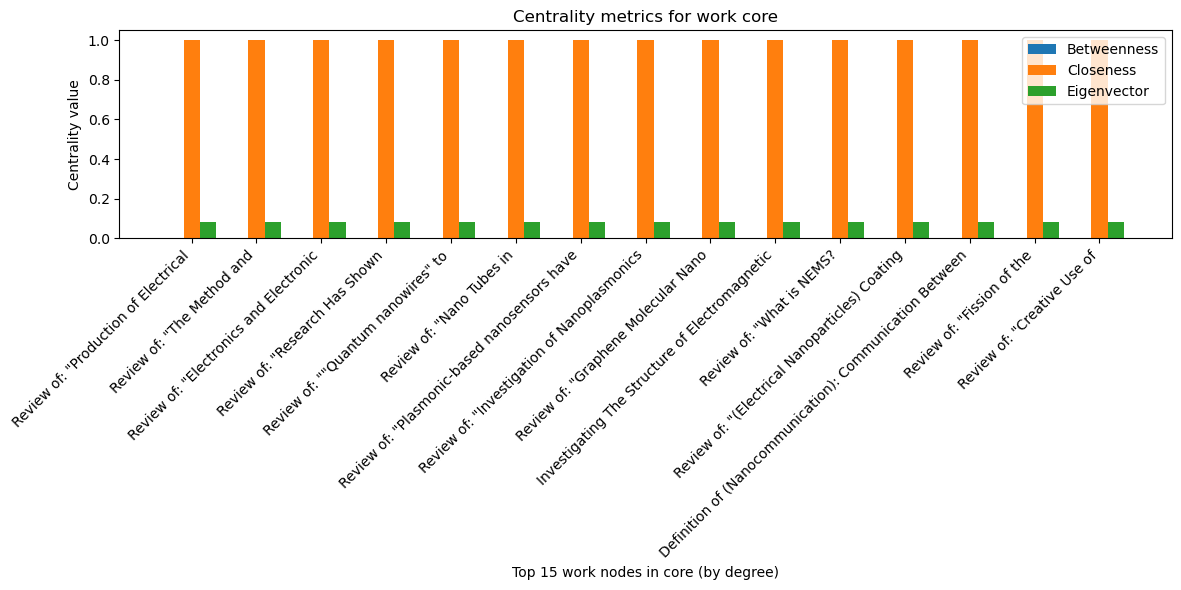

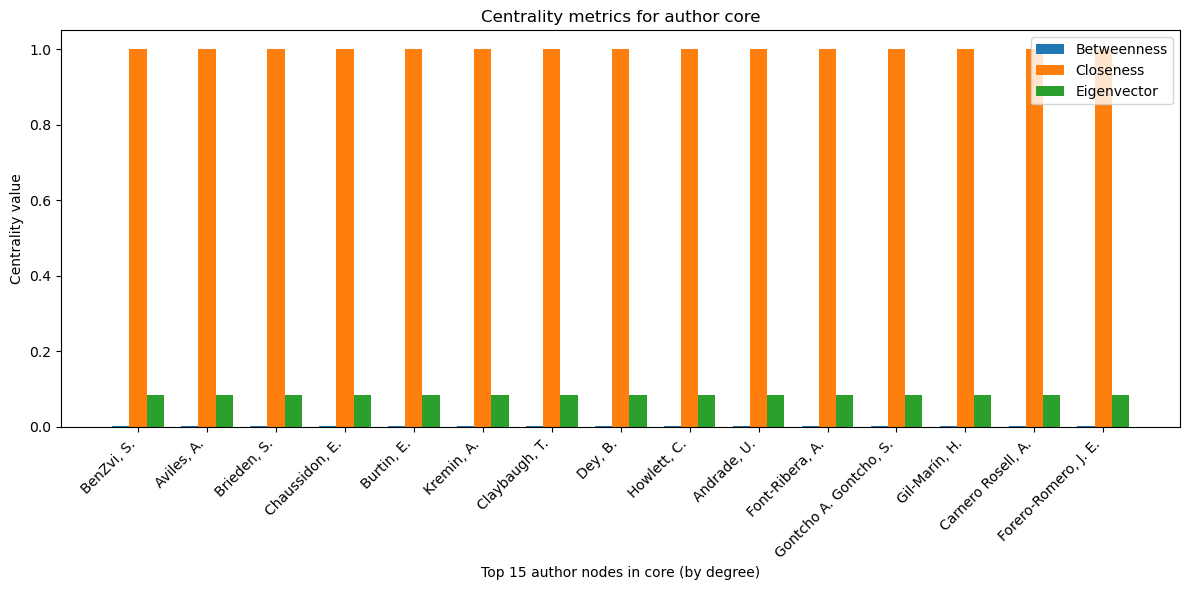

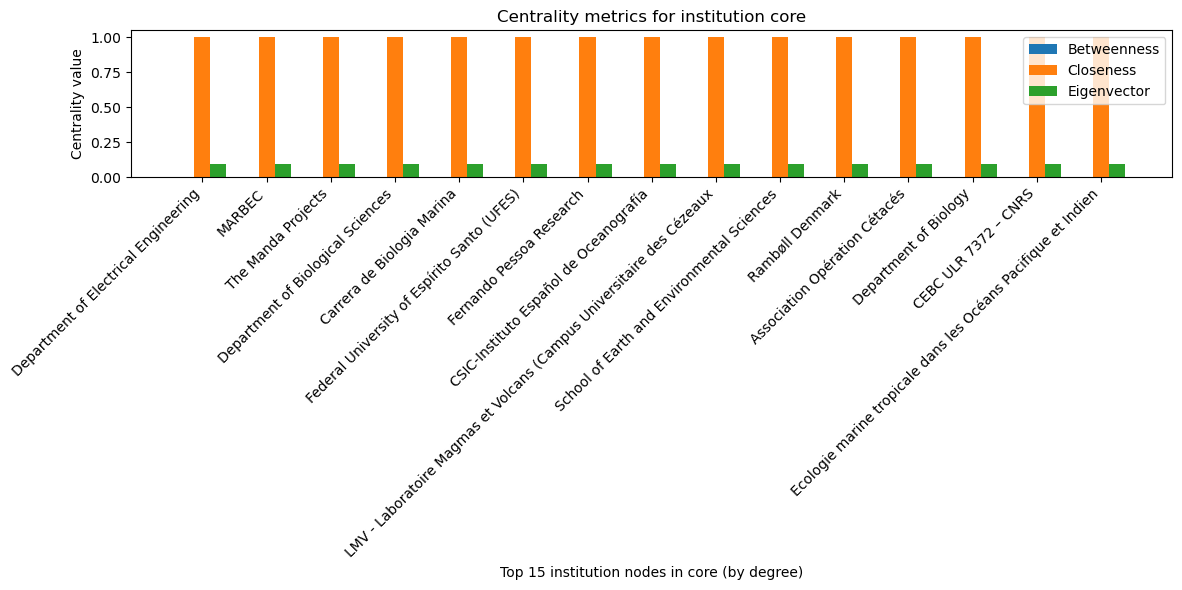

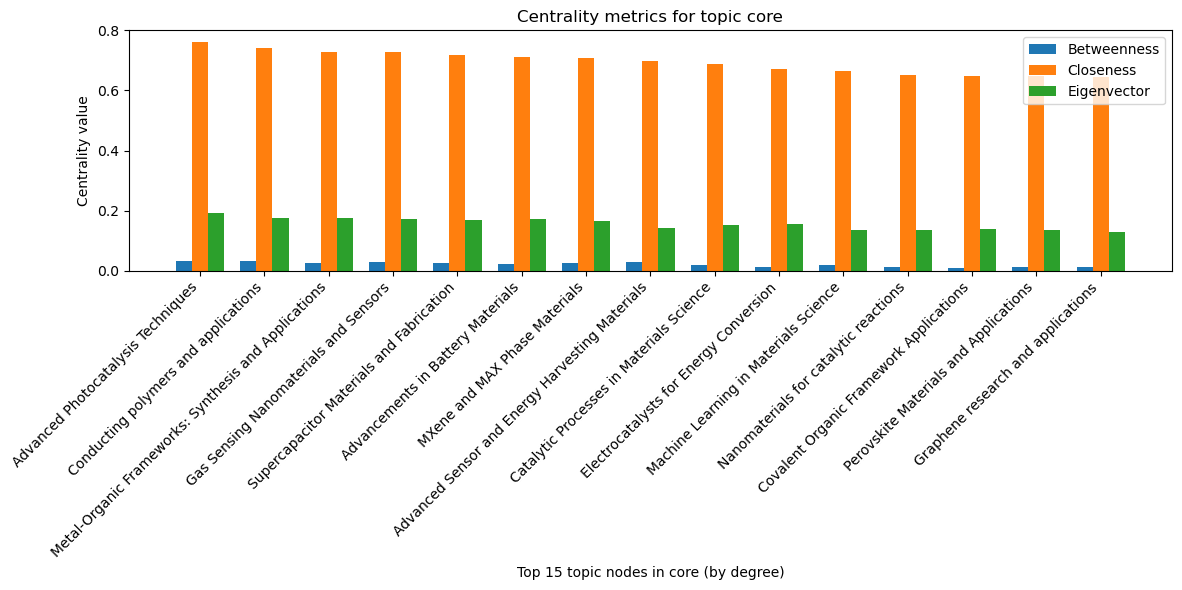

In [24]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

################################################################################################################################
# Helper: safe listify

def safe_list(x):
    """Convert NaN/None/arrays/etc. into a clean Python list."""
    if x is None:
        return []
    if isinstance(x, float) and pd.isna(x):
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    if hasattr(x, "tolist"):
        return list(x.tolist())
    return [x]

################################################################################################################################
# WORK–WORK PROJECTION (shared authors)
print("Building Work–Work projection (shared authors)...")

# Use work_author_edges: each row is (work_id, author_id, ...)
wa = work_author_edges.dropna(subset=["author_id"]).copy()

# Map author -> list of works
author_to_works = (
    wa.groupby("author_id")["work_id"]
      .apply(lambda s: sorted(set(s)))
)

# Build weighted edges between works that share an author
ww_edges = {}
for works in author_to_works:
    if len(works) < 2:
        continue
    for w1, w2 in combinations(works, 2):
        if w1 == w2:
            continue
        key = (w1, w2) if w1 < w2 else (w2, w1)
        ww_edges[key] = ww_edges.get(key, 0) + 1

G_w_full = nx.Graph()

# Add work nodes + attributes
for _, row in work_nodes.iterrows():
    G_w_full.add_node(
        row["work_id"],
        node_type="work",
        title=row["title"],
        publication_year=row["publication_year"],
        language=row["language"],
        cited_by_count=row["cited_by_count"],
    )

# Add edges with weight=shared authors
for (w1, w2), wgt in ww_edges.items():
    if w1 in G_w_full and w2 in G_w_full:
        G_w_full.add_edge(w1, w2, weight=wgt)

print(f"Work–Work graph: {G_w_full.number_of_nodes()} nodes, {G_w_full.number_of_edges()} edges")

################################################################################################################################
# AUTHOR–AUTHOR PROJECTION (co-authors)

print("\nBuilding Author–Author projection (co-authors)...")

# Map work -> list of authors
work_to_authors = (
    wa.groupby("work_id")["author_id"]
      .apply(lambda s: sorted(set(s)))
)

aa_edges = {}
for authors in work_to_authors:
    if len(authors) < 2:
        continue
    for a1, a2 in combinations(authors, 2):
        if a1 == a2:
            continue
        key = (a1, a2) if a1 < a2 else (a2, a1)
        aa_edges[key] = aa_edges.get(key, 0) + 1

G_a_full = nx.Graph()
# Add author nodes + attributes
for _, row in author_nodes.iterrows():
    G_a_full.add_node(
        row["author_id"],
        node_type="author",
        raw_author_name=row["raw_author_name"],
        author_institution_ids=row["author_institution_ids"],
        author_raw_affiliations=row["author_raw_affiliations"],
    )

for (a1, a2), wgt in aa_edges.items():
    if a1 in G_a_full and a2 in G_a_full:
        G_a_full.add_edge(a1, a2, weight=wgt)

print(f"Author–Author graph: {G_a_full.number_of_nodes()} nodes, {G_a_full.number_of_edges()} edges")

################################################################################################################################
# INSTITUTION–INSTITUTION PROJECTION (co-affiliation on a work)

print("\nBuilding Institution–Institution projection (co-affiliations)...")

# From work_author_edges, get institutions per work
wa_inst = work_author_edges.copy()
wa_inst["author_institution_ids"] = wa_inst["author_institution_ids"].apply(safe_list)

work_to_insts = (
    wa_inst.groupby("work_id")["author_institution_ids"]
           .apply(lambda lists: sorted({inst for sub in lists for inst in sub}))
)

ii_edges = {}
for insts in work_to_insts:
    if len(insts) < 2:
        continue
    for i1, i2 in combinations(insts, 2):
        if i1 == i2:
            continue
        key = (i1, i2) if i1 < i2 else (i2, i1)
        ii_edges[key] = ii_edges.get(key, 0) + 1

# Build a simple institution attribute map (example affiliation)
inst_attr = {}
for _, row in author_nodes.iterrows():
    inst_ids = safe_list(row["author_institution_ids"])
    affs = safe_list(row["author_raw_affiliations"])
    example_aff = affs[0] if affs else None
    for inst in inst_ids:
        inst_attr.setdefault(inst, {"example_affiliation": example_aff})

G_i_full = nx.Graph()
for inst_id, attrs in inst_attr.items():
    G_i_full.add_node(
        inst_id,
        node_type="institution",
        example_affiliation=attrs["example_affiliation"],
    )

for (i1, i2), wgt in ii_edges.items():
    if i1 in G_i_full and i2 in G_i_full:
        G_i_full.add_edge(i1, i2, weight=wgt)

print(f"Institution–Institution graph: {G_i_full.number_of_nodes()} nodes, {G_i_full.number_of_edges()} edges")

################################################################################################################################
# TOPIC–TOPIC PROJECTION (co-occurring topics on works)

print("\nBuilding Topic–Topic projection (co-occurring topics)...")

wt = work_topic_edges.copy()

topic_work_map = (
    wt.groupby("work_id")["topic_id"]
      .apply(lambda s: sorted(set(s)))
)

tt_edges = {}
for topics in topic_work_map:
    if len(topics) < 2:
        continue
    for t1, t2 in combinations(topics, 2):
        if t1 == t2:
            continue
        key = (t1, t2) if t1 < t2 else (t2, t1)
        tt_edges[key] = tt_edges.get(key, 0) + 1

G_t_full = nx.Graph()
for _, row in topic_nodes.iterrows():
    G_t_full.add_node(
        row["topic_id"],
        node_type="topic",
        topic_name=row["topic_name"],
        topic_domain=row["topic_domain"],
        topic_field=row["topic_field"],
        topic_subfield=row["topic_subfield"],
    )

for (t1, t2), wgt in tt_edges.items():
    if t1 in G_t_full and t2 in G_t_full:
        G_t_full.add_edge(t1, t2, weight=wgt)

print(f"Topic–Topic graph: {G_t_full.number_of_nodes()} nodes, {G_t_full.number_of_edges()} edges")

################################################################################################################################
# Extract max k-core for each projection

def max_k_core(G):
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return G, 0
    core_nums = nx.core_number(G)
    max_k = max(core_nums.values())
    core = nx.k_core(G, max_k)
    return core, max_k

G_w, k_w = max_k_core(G_w_full)
G_a, k_a = max_k_core(G_a_full)
G_i, k_i = max_k_core(G_i_full)
G_t, k_t = max_k_core(G_t_full)

print("\n=== Max k-core summaries ===")
print(f"G_w (Works–Works core):       k={k_w}, nodes={G_w.number_of_nodes()}, edges={G_w.number_of_edges()}")
print(f"G_a (Authors–Authors core):   k={k_a}, nodes={G_a.number_of_nodes()}, edges={G_a.number_of_edges()}")
print(f"G_i (Inst–Inst core):         k={k_i}, nodes={G_i.number_of_nodes()}, edges={G_i.number_of_edges()}")
print(f"G_t (Topics–Topics core):     k={k_t}, nodes={G_t.number_of_nodes()}, edges={G_t.number_of_edges()}")



################################################################################################################################
# Centrality + grouped bar plots per core

def centrality_df_for_core(G):
    if G.number_of_nodes() == 0:
        return pd.DataFrame()
    deg_c = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, normalized=True)
    clo = nx.closeness_centrality(G)
    eig = nx.eigenvector_centrality(G, max_iter=1000)
    rows = []
    for n in G.nodes():
        rows.append({
            "node": n,
            "degree": G.degree[n],
            "degree_centrality": deg_c[n],
            "betweenness": bet[n],
            "closeness": clo[n],
            "eigenvector": eig[n],
        })
    return pd.DataFrame(rows)

def label_for_node_generic(G, node, graph_type, max_words=5):
    attrs = G.nodes[node]
    if graph_type == "work":
        title = attrs.get("title")
        if isinstance(title, str):
            return " ".join(title.split()[:max_words])
    elif graph_type == "author":
        name = attrs.get("raw_author_name")
        if isinstance(name, str):
            return name
    elif graph_type == "topic":
        tname = attrs.get("topic_name")
        if isinstance(tname, str):
            return tname
    elif graph_type == "institution":
        aff = attrs.get("example_affiliation")
        if isinstance(aff, str) and aff:
            return aff.split(",")[0]  # first chunk of affiliation as label

    # Fallback: tail of ID
    if isinstance(node, str) and "/" in node:
        return node.rsplit("/", 1)[-1]
    return str(node)

def plot_core_centralities(G, graph_type, top_k=15):
    """
    Plot a grouped bar chart (betweenness, closeness, eigenvector) for top_k nodes in the given core graph (G)
    """
    df = centrality_df_for_core(G)
    if df.empty:
        print(f"\nNo nodes in {graph_type} core; skipping plot.")
        return

    # sort by degree
    df = df.sort_values("degree", ascending=False).head(top_k)

    indices = np.arange(len(df))
    width = 0.25
    
    # Metrics
    bet = df["betweenness"].values
    clo = df["closeness"].values
    eig = df["eigenvector"].values

    labels = [label_for_node_generic(G, n, graph_type, max_words=5) for n in df["node"]]

    plt.figure(figsize=(12, 6))
    plt.bar(indices - width, bet, width, label="Betweenness")
    plt.bar(indices,         clo, width, label="Closeness")
    plt.bar(indices + width, eig, width, label="Eigenvector")

    plt.xticks(indices, labels, rotation=45, ha="right")
    plt.xlabel(f"Top {len(df)} {graph_type} nodes in core (by degree)")
    plt.ylabel("Centrality value")
    plt.title(f"Centrality metrics for {graph_type} core")
    plt.legend()
    plt.tight_layout()
    plt.show()

################################################################################################################################
# Plot centrality bars for each of the four cores
plot_core_centralities(G_w, graph_type="work",        top_k=15)
plot_core_centralities(G_a, graph_type="author",      top_k=15)
plot_core_centralities(G_i, graph_type="institution", top_k=15)
plot_core_centralities(G_t, graph_type="topic",       top_k=15)

#### Deeper Analysis across 4 Node Types

    With my overall core made and basic metrics visualized, I want to see more detail - for example, from the Authors core, what Works, Institutions, and Topics are they connected to? From the Works core, what are the connected Authors, Topics, and citation metrics? From the Institutions core, what Topics do they focus their research on, and what Authors work with them?

In [25]:
import pandas as pd
import numpy as np

def inspect_core(
    max_works=10,
    max_authors=10,
    max_topics=10,
    max_institutions=10,
    **kwargs
):
    """
    Inspect one entity in the network and list related Works, Authors, Topics, Institutions.

    Usage examples:
      inspect_core(Author="Kirkby")
      inspect_core(Work="transformer")
      inspect_core(Topic="fusion")
      inspect_core(Institution="MIT")

    Exactly ONE of (work, author, topic, institution) should be provided, case-insensitive in argument name.
    """

    # ------------------------------------------------------------------
    # Normalize which argument was passed (case-insensitive)
    # ------------------------------------------------------------------
    allowed = ["work", "author", "topic", "institution"]
    chosen = None
    query = None
    for k, v in kwargs.items():
        lk = k.lower()
        if lk in allowed and v is not None:
            if chosen is not None:
                print(f"Please specify only ONE of: {allowed}. Got multiple: {chosen}, {lk}")
                return None
            chosen = lk
            query = str(v)

    if chosen is None:
        print(f"Please call inspect_core with exactly one of: {allowed}")
        return None

    kind = chosen
    q_lower = query.lower()

    # For returning structured pieces
    result = {
        "node_type": kind,
        "query": query,
        "selected": None,         # the matching row or dict
        "centrality_row": None,   # centrality row if available
        "works": None,
        "authors": None,
        "topics": None,
        "institutions": None,
    }

    # Helper to normalize list-like values
    def safe_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, (tuple, np.ndarray)):
            return list(x)
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return []
        return [x]

    # ==========================================================
    # 1) WORK: search work_nodes by title or work_id substring
    # ==========================================================
    if kind == "work":
        if "work_nodes" not in globals():
            print("work_nodes not found in the environment.")
            return None

        df = work_nodes.copy()

        mask = (
            df["title"].astype(str).str.contains(q_lower, case=False, na=False)
            | df["work_id"].astype(str).str.contains(q_lower, case=False, na=False)
        )
        matches = df[mask]

        if matches.empty:
            print(f"No works found matching '{query}'.")
            return None

        print(f"Found {len(matches)} work(s) matching '{query}':")
        for _, row in matches.head(10).iterrows():
            short_title = " ".join(str(row["title"]).split()[:10])
            print(
                f"  - {short_title}... "
                f"(year={row['publication_year']}, cited_by={row['cited_by_count']}, id={row['work_id']})"
            )
        if len(matches) > 10:
            print("  ... (showing first 10)")

        # Pick the first match as the focal work
        target = matches.iloc[0]
        target_id = target["work_id"]
        result["selected"] = target

        print("\nInspecting first matched work:")
        print(
            f"Title: {target['title']}\n"
            f"Year:  {target['publication_year']}\n"
            f"Cited: {target['cited_by_count']}\n"
            f"ID:    {target_id}"
        )

        # Centrality from Work–Work core, if available
        if "w_core_cent" in globals():
            rowc = w_core_cent[w_core_cent["node"] == target_id]
            if not rowc.empty:
                rc = rowc.iloc[0]
                result["centrality_row"] = rc
                print("\nCentrality in Work–Work core (G_w):")
                print(f"  degree:             {rc['degree']}")
                print(f"  degree_centrality:  {rc['degree_centrality']:.4g}")
                print(f"  betweenness:        {rc['betweenness']:.4g}")
                print(f"  closeness:          {rc['closeness']:.4g}")
                print(f"  eigenvector:        {rc['eigenvector']:.4g}")
            else:
                print("\nWork not present in Work–Work core (no centrality row).")

        # Related Authors & Institutions (via work_author_edges)
        if "work_author_edges" in globals():
            wa = work_author_edges.dropna(subset=["authorships"]).copy()
            wa["author_institution_ids"] = wa["author_institution_ids"].apply(safe_list)
            wa["author_raw_affiliations"] = wa["author_raw_affiliations"].apply(safe_list)

            sub_wa = wa[wa["work_id"] == target_id].copy()

            # Authors on this work
            if not sub_wa.empty:
                # One row per author
                sub_wa = sub_wa.dropna(subset=["author_id"])
                auth_summary = (
                    sub_wa.groupby("author_id", dropna=True)
                    .agg(n_edges=("work_id", "size"))
                    .reset_index()
                )
                if "author_nodes" in globals():
                    ainfo = author_nodes.set_index("author_id")
                    auth_summary = auth_summary.join(
                        ainfo[["raw_author_name"]], on="author_id", how="left"
                    )
                auth_summary = auth_summary.sort_values("n_edges", ascending=False)
                print(f"\nAuthors on this work (top {min(max_authors, len(auth_summary))}):")
                for _, r in auth_summary.head(max_authors).iterrows():
                    print(f"  - {r['raw_author_name']} ({r['author_id']})")
                result["authors"] = auth_summary
            else:
                print("\nNo authors found for this work in work_author_edges.")

            # Institutions via authorships
            inst_rows = []
            for _, r in sub_wa.iterrows():
                inst_ids = safe_list(r["author_institution_ids"])
                affs = safe_list(r["author_raw_affiliations"])
                if not inst_ids:
                    continue
                if not affs:
                    affs = ["N/A"]
                for iid in inst_ids:
                    inst_rows.append(
                        {"institution_id": iid, "affiliation_example": affs[0]}
                    )
            if inst_rows:
                inst_df = pd.DataFrame(inst_rows)
                inst_summary = (
                    inst_df.groupby(["institution_id", "affiliation_example"], dropna=False)
                    .size()
                    .reset_index(name="count_edges")
                    .sort_values("count_edges", ascending=False)
                )
                print(f"\nInstitutions for this work (top {min(max_institutions, len(inst_summary))}):")
                for _, r in inst_summary.head(max_institutions).iterrows():
                    print(
                        f"  - {r['affiliation_example']} "
                        f"({r['institution_id']}) – edges={r['count_edges']}"
                    )
                result["institutions"] = inst_summary
            else:
                print("\nNo institutions found for this work.")

        # Topics (via work_topic_edges)
        if "work_topic_edges" in globals():
            wt = work_topic_edges[work_topic_edges["work_id"] == target_id].copy()
            if not wt.empty:
                wt = wt.sort_values("topic_score", ascending=False)
                print(f"\nTopics for this work (top {min(max_topics, len(wt))}):")
                for _, r in wt.head(max_topics).iterrows():
                    print(
                        f"  - {r['topic_name']} "
                        f"(score={r['topic_score']:.3f}, field={r['topic_field']}, subfield={r['topic_subfield']})"
                    )
                result["topics"] = wt
            else:
                print("\nNo topics found for this work in work_topic_edges.")

        result["works"] = pd.DataFrame([target])
        return result

    # ==========================================================
    # 2) AUTHOR: search author_nodes by name or author_id
    # ==========================================================
    if kind == "author":
        if "author_nodes" not in globals():
            print("author_nodes not found in the environment.")
            return None

        df = author_nodes.copy()

        mask = (
            df["raw_author_name"].astype(str).str.contains(q_lower, case=False, na=False)
            | df["author_id"].astype(str).str.contains(q_lower, case=False, na=False)
        )
        matches = df[mask]

        if matches.empty:
            print(f"No authors found matching '{query}'.")
            return None

        print(f"Found {len(matches)} author(s) matching '{query}':")
        for _, row in matches.head(10).iterrows():
            print(f"  - {row['raw_author_name']} ({row['author_id']})")
        if len(matches) > 10:
            print("  ... (showing first 10)")

        target = matches.iloc[0]
        aid = target["author_id"]
        result["selected"] = target

        print("\nInspecting first matched author:")
        print(f"Author: {target['raw_author_name']}\nID:     {aid}")

        # Centrality from Author–Author core
        if "a_core_cent" in globals():
            rowc = a_core_cent[a_core_cent["node"] == aid]
            if not rowc.empty:
                rc = rowc.iloc[0]
                result["centrality_row"] = rc
                print("\nCentrality in Author–Author core (G_a):")
                print(f"  degree:             {rc['degree']}")
                print(f"  degree_centrality:  {rc['degree_centrality']:.4g}")
                print(f"  betweenness:        {rc['betweenness']:.4g}")
                print(f"  closeness:          {rc['closeness']:.4g}")
                print(f"  eigenvector:        {rc['eigenvector']:.4g}")
            else:
                print("\nAuthor not present in Author–Author core (no centrality row).")

        # Works for this author
        if "work_author_edges" in globals():
            wa = work_author_edges.dropna(subset=["author_id"]).copy()
            wa["author_institution_ids"] = wa["author_institution_ids"].apply(safe_list)
            wa["author_raw_affiliations"] = wa["author_raw_affiliations"].apply(safe_list)

            sub_wa = wa[wa["author_id"] == aid].copy()

            if not sub_wa.empty and "work_nodes" in globals():
                work_ids = sub_wa["work_id"].unique().tolist()
                wsub = work_nodes[work_nodes["work_id"].isin(work_ids)].copy()
                wsub = wsub.sort_values("cited_by_count", ascending=False)
                print(f"\nWorks for this author (top {min(max_works, len(wsub))}):")
                for _, r in wsub.head(max_works).iterrows():
                    short_title = " ".join(str(r["title"]).split()[:10])
                    print(
                        f"  - {short_title}..."
                        f" (year={r['publication_year']}, cited_by={r['cited_by_count']}, id={r['work_id']})"
                    )
                result["works"] = wsub
            else:
                print("\nNo works found for this author in work_author_edges or work_nodes missing.")

            # Institutions
            inst_rows = []
            for _, r in sub_wa.iterrows():
                inst_ids = safe_list(r["author_institution_ids"])
                affs = safe_list(r["author_raw_affiliations"])
                if not inst_ids:
                    continue
                if not affs:
                    affs = ["N/A"]
                for iid in inst_ids:
                    inst_rows.append(
                        {"institution_id": iid, "affiliation_example": affs[0]}
                    )

            if inst_rows:
                inst_df = pd.DataFrame(inst_rows)
                inst_summary = (
                    inst_df.groupby(["institution_id", "affiliation_example"], dropna=False)
                    .size()
                    .reset_index(name="count_works")
                    .sort_values("count_works", ascending=False)
                )
                print(f"\nInstitutions for this author (top {min(max_institutions, len(inst_summary))}):")
                for _, r in inst_summary.head(max_institutions).iterrows():
                    print(
                        f"  - {r['affiliation_example']} "
                        f"({r['institution_id']}) – {r['count_works']} work(s)"
                    )
                result["institutions"] = inst_summary
            else:
                print("\nNo institutions found for this author.")

        # Topics via the author's works
        if "work_topic_edges" in globals() and result["works"] is not None:
            w_ids = result["works"]["work_id"].unique().tolist()
            wt = work_topic_edges[work_topic_edges["work_id"].isin(w_ids)].copy()
            if not wt.empty:
                topic_summary = (
                    wt.groupby(
                        ["topic_id", "topic_name", "topic_field", "topic_subfield"],
                        dropna=False,
                    )
                    .size()
                    .reset_index(name="n_works")
                    .sort_values("n_works", ascending=False)
                )
                print(f"\nTop topics for this author (top {min(max_topics, len(topic_summary))}):")
                for _, r in topic_summary.head(max_topics).iterrows():
                    print(
                        f"  - {r['topic_name']} "
                        f"(field={r['topic_field']}, subfield={r['topic_subfield']}) – "
                        f"{r['n_works']} work(s)"
                    )
                result["topics"] = topic_summary
            else:
                print("\nNo topics found for this author's works.")

        result["authors"] = pd.DataFrame([target])
        return result

    # ==========================================================
    # 3) TOPIC: search topic_nodes by name or ID
    # ==========================================================
    if kind == "topic":
        if "topic_nodes" not in globals():
            print("topic_nodes not found in the environment.")
            return None

        df = topic_nodes.copy()
        mask = (
            df["topic_name"].astype(str).str.contains(q_lower, case=False, na=False)
            | df["topic_id"].astype(str).str.contains(q_lower, case=False, na=False)
        )
        matches = df[mask]

        if matches.empty:
            print(f"No topics found matching '{query}'.")
            return None

        print(f"Found {len(matches)} topic(s) matching '{query}':")
        for _, row in matches.head(10).iterrows():
            print(
                f"  - {row['topic_name']} "
                f"(field={row['topic_field']}, subfield={row['topic_subfield']}, id={row['topic_id']})"
            )
        if len(matches) > 10:
            print("  ... (showing first 10)")

        target = matches.iloc[0]
        tid = target["topic_id"]
        result["selected"] = target

        print("\nInspecting first matched topic:")
        print(
            f"Topic:    {target['topic_name']}\n"
            f"Field:    {target['topic_field']}\n"
            f"Subfield: {target['topic_subfield']}\n"
            f"ID:       {tid}"
        )

        # Centrality from Topic–Topic core
        if "t_core_cent" in globals():
            rowc = t_core_cent[t_core_cent["node"] == tid]
            if not rowc.empty:
                rc = rowc.iloc[0]
                result["centrality_row"] = rc
                print("\nCentrality in Topic–Topic core (G_t):")
                print(f"  degree:             {rc['degree']}")
                print(f"  degree_centrality:  {rc['degree_centrality']:.4g}")
                print(f"  betweenness:        {rc['betweenness']:.4g}")
                print(f"  closeness:          {rc['closeness']:.4g}")
                print(f"  eigenvector:        {rc['eigenvector']:.4g}")
            else:
                print("\nTopic not present in Topic–Topic core (no centrality row).")

        # Works on this topic
        if "work_topic_edges" in globals():
            wt = work_topic_edges[work_topic_edges["topic_id"] == tid].copy()
            if not wt.empty and "work_nodes" in globals():
                w_ids = wt["work_id"].unique().tolist()
                wsub = work_nodes[work_nodes["work_id"].isin(w_ids)].copy()
                wsub = wsub.sort_values("cited_by_count", ascending=False)
                print(f"\nWorks on this topic (top {min(max_works, len(wsub))}):")
                for _, r in wsub.head(max_works).iterrows():
                    short_title = " ".join(str(r["title"]).split()[:10])
                    print(
                        f"  - {short_title}..."
                        f" (year={r['publication_year']}, cited_by={r['cited_by_count']}, id={r['work_id']})"
                    )
                result["works"] = wsub
            else:
                print("\nNo works found for this topic in work_topic_edges or work_nodes missing.")

        # Authors & Institutions via those works
        if "work_author_edges" in globals() and result["works"] is not None:
            wa = work_author_edges.dropna(subset=["author_id"]).copy()
            wa["author_institution_ids"] = wa["author_institution_ids"].apply(safe_list)
            wa["author_raw_affiliations"] = wa["author_raw_affiliations"].apply(safe_list)

            w_ids = result["works"]["work_id"].unique().tolist()
            sub_wa = wa[wa["work_id"].isin(w_ids)].copy()

            # Authors
            if not sub_wa.empty:
                auth_summary = (
                    sub_wa.groupby("author_id", dropna=True)
                    .agg(n_works=("work_id", "nunique"))
                    .reset_index()
                )
                if "author_nodes" in globals():
                    ainfo = author_nodes.set_index("author_id")
                    auth_summary = auth_summary.join(
                        ainfo[["raw_author_name"]], on="author_id", how="left"
                    )
                auth_summary = auth_summary.sort_values("n_works", ascending=False)
                print(f"\nTop authors on this topic (top {min(max_authors, len(auth_summary))}):")
                for _, r in auth_summary.head(max_authors).iterrows():
                    print(
                        f"  - {r['raw_author_name']} ({r['author_id']}) – "
                        f"{r['n_works']} work(s)"
                    )
                result["authors"] = auth_summary
            else:
                print("\nNo authors found for this topic's works.")

            # Institutions
            inst_rows = []
            for _, r in sub_wa.iterrows():
                inst_ids = safe_list(r["author_institution_ids"])
                affs = safe_list(r["author_raw_affiliations"])
                if not inst_ids:
                    continue
                if not affs:
                    affs = ["N/A"]
                for iid in inst_ids:
                    inst_rows.append(
                        {"institution_id": iid, "affiliation_example": affs[0]}
                    )

            if inst_rows:
                inst_df = pd.DataFrame(inst_rows)
                inst_summary = (
                    inst_df.groupby(["institution_id", "affiliation_example"], dropna=False)
                    .size()
                    .reset_index(name="n_works")
                    .sort_values("n_works", ascending=False)
                )
                print(f"\nTop institutions on this topic (top {min(max_institutions, len(inst_summary))}):")
                for _, r in inst_summary.head(max_institutions).iterrows():
                    print(
                        f"  - {r['affiliation_example']} "
                        f"({r['institution_id']}) – {r['n_works']} work(s)"
                    )
                result["institutions"] = inst_summary
            else:
                print("\nNo institutions found for this topic's works.")

        result["topics"] = pd.DataFrame([target])
        return result

    # ==========================================================
    # 4) INSTITUTION: search by substring in affiliation text
    # ==========================================================
    if kind == "institution":
        if "work_author_edges" not in globals():
            print("work_author_edges not found in the environment.")
            return None

        wa = work_author_edges.copy()
        wa["author_institution_ids"] = wa["author_institution_ids"].apply(safe_list)
        wa["author_raw_affiliations"] = wa["author_raw_affiliations"].apply(safe_list)

        # Build mapping: inst_id -> set of affiliation strings
        inst_affs = {}
        for _, r in wa.iterrows():
            inst_ids = r["author_institution_ids"]
            affs = r["author_raw_affiliations"]
            if not inst_ids or not affs:
                continue
            for iid in inst_ids:
                if iid not in inst_affs:
                    inst_affs[iid] = set()
                for s in affs:
                    if isinstance(s, str):
                        inst_affs[iid].add(s)

        # Find candidates with substring in any affiliation string
        candidates = []
        for iid, affset in inst_affs.items():
            matches_here = [s for s in affset if q_lower in s.lower()]
            if matches_here:
                candidates.append((iid, matches_here[0]))

        if not candidates:
            print(f"No institutions found with affiliation text containing '{query}'.")
            return None

        print(f"Found {len(candidates)} institution(s) matching '{query}':")
        for iid, ex in candidates[:10]:
            print(f"  - {ex} ({iid})")
        if len(candidates) > 10:
            print("  ... (showing first 10)")

        # Take the first candidate
        target_id, ex_aff = candidates[0]
        result["selected"] = {"institution_id": target_id, "affiliation_example": ex_aff}

        print("\nInspecting first matched institution:")
        print(f"Institution ID: {target_id}\nExample affil: {ex_aff}")

        # Centrality from Institution–Institution core
        if "i_core_cent" in globals():
            rowc = i_core_cent[i_core_cent["node"] == target_id]
            if not rowc.empty:
                rc = rowc.iloc[0]
                result["centrality_row"] = rc
                print("\nCentrality in Institution–Institution core (G_i):")
                print(f"  degree:             {rc['degree']}")
                print(f"  degree_centrality:  {rc['degree_centrality']:.4g}")
                print(f"  betweenness:        {rc['betweenness']:.4g}")
                print(f"  closeness:          {rc['closeness']:.4g}")
                print(f"  eigenvector:        {rc['eigenvector']:.4g}")
            else:
                print("\nInstitution not present in Institution–Institution core (no centrality row).")

        # Rows for this institution
        rows_for_inst = []
        for _, r in wa.iterrows():
            inst_ids = r["author_institution_ids"]
            if target_id in inst_ids:
                rows_for_inst.append(r)
        if not rows_for_inst:
            print("\nNo authorships found for this institution.")
            return result

        sub_wa = pd.DataFrame(rows_for_inst)

        # Works
        if "work_nodes" in globals():
            w_ids = sub_wa["work_id"].unique().tolist()
            wsub = work_nodes[work_nodes["work_id"].isin(w_ids)].copy()
            wsub = wsub.sort_values("cited_by_count", ascending=False)
            print(f"\nWorks at this institution (top {min(max_works, len(wsub))}):")
            for _, r in wsub.head(max_works).iterrows():
                short_title = " ".join(str(r["title"]).split()[:10])
                print(
                    f"  - {short_title}..."
                    f" (year={r['publication_year']}, cited_by={r['cited_by_count']}, id={r['work_id']})"
                )
            result["works"] = wsub
        else:
            print("\nwork_nodes not found; cannot list works.")

        # Authors
        auth_summary = (
            sub_wa.groupby("author_id", dropna=True)
            .agg(n_works=("work_id", "nunique"))
            .reset_index()
        )
        if "author_nodes" in globals():
            ainfo = author_nodes.set_index("author_id")
            auth_summary = auth_summary.join(
                ainfo[["raw_author_name"]], on="author_id", how="left"
            )
        auth_summary = auth_summary.sort_values("n_works", ascending=False)
        print(f"\nTop authors at this institution (top {min(max_authors, len(auth_summary))}):")
        for _, r in auth_summary.head(max_authors).iterrows():
            print(
                f"  - {r['raw_author_name']} ({r['author_id']}) – "
                f"{r['n_works']} work(s)"
            )
        result["authors"] = auth_summary

        # Topics
        if "work_topic_edges" in globals() and result["works"] is not None:
            w_ids = result["works"]["work_id"].unique().tolist()
            wt = work_topic_edges[work_topic_edges["work_id"].isin(w_ids)].copy()
            if not wt.empty:
                topic_summary = (
                    wt.groupby(
                        ["topic_id", "topic_name", "topic_field", "topic_subfield"],
                        dropna=False,
                    )
                    .size()
                    .reset_index(name="n_works")
                    .sort_values("n_works", ascending=False)
                )
                print(f"\nTop topics for this institution (top {min(max_topics, len(topic_summary))}):")
                for _, r in topic_summary.head(max_topics).iterrows():
                    print(
                        f"  - {r['topic_name']} "
                        f"(field={r['topic_field']}, subfield={r['topic_subfield']}) – "
                        f"{r['n_works']} work(s)"
                    )
                result["topics"] = topic_summary
            else:
                print("\nNo topics found for this institution's works.")

        result["institutions"] = pd.DataFrame(
            [{"institution_id": target_id, "affiliation_example": ex_aff}]
        )
        return result


In [26]:
# Work search 
res_work = inspect_core(Work="transformer", max_authors=10)
print("-----------------------------------------------------------------------------------------------------------------------------")

# Author search
res_author = inspect_core(Author="Kirkby", max_works=5)
print("-----------------------------------------------------------------------------------------------------------------------------")

# Topic search
res_topic = inspect_core(Topic="fusion", max_works=5, max_authors=10, max_institutions=10)
print("-----------------------------------------------------------------------------------------------------------------------------")

# Institution search
res_inst = inspect_core(Institution="Google", max_works=5, max_authors=10, max_topics=10)
print("-----------------------------------------------------------------------------------------------------------------------------")


Found 181 work(s) matching 'transformer':
  - Enhancing the Spatial Resolution of Sentinel-2 Images Through Super-Resolution Using... (year=2025, cited_by=60, id=https://openalex.org/W4406089633)
  - MambaVision: A Hybrid Mamba-Transformer Vision Backbone... (year=2025, cited_by=59, id=https://openalex.org/W4413146579)
  - pACP-HybDeep: predicting anticancer peptides using binary tree growth based transformer... (year=2025, cited_by=53, id=https://openalex.org/W4406015449)
  - Ni-decorated WS <sub>2</sub> -WSe <sub>2</sub> heterostructure as a novel sensing... (year=2025, cited_by=53, id=https://openalex.org/W4409519776)
  - MB-TaylorFormer V2: Improved Multi-Branch Linear Transformer Expanded by Taylor Formula... (year=2025, cited_by=48, id=https://openalex.org/W4409326045)
  - A regularized transformer with adaptive token fusion for Alzheimer's disease... (year=2025, cited_by=48, id=https://openalex.org/W4410328418)
  - Vision Transformers for Image Classification: A Comparative Surv

#### NLP Approach

    With a deeper understanding of my data from an SNA approach, I will now pivot to seeing what analysis can be done with NLP. My Physical Sciences corpus contains the Topics JSON structure, which has high-level descriptions good for topic modeling and embedding similarity. It contains keywords for weighted extraction, hierarchical placement (Domain/Field/Subfield), related topics, and is linked to Works with titles and abstracts. I will tackle NLP as listed at the start:

---

1) Text Cleaning & Preprocessing:

       - Tokenize, normalize, and lemmatize the text from titles and abstracts; remove stopwords; clean text for downstream tasks.

2) Keyword Extraction:
   
        - Use TF-IDF and n-gram analysis to identify high-frequency scientific concepts, methods, and domain-specific terminology.

3) Topic Modeling:
   
        - Apply NMF topic modeling to reveal major research themes, topics, and clusters of related scientific works. This can be a useful substitute if an OpenAlex Work is missing a topic.

4) Keyphrase Identification:

        - Extract technical phrases and scientific terms to characterize fields or subfields, and their metrics.


In [27]:
# Requires installing the most recent version of Spacy (3.8), which I have done in an Anaconda command for Python virtual environment 3.10.19: 

#conda create -n nlp_env python=3.10
#conda activate nlp_env
#conda install scikit-learn
#pip install spacy
#pip install jupyter
#python -m spacy download en_core_web_sm
#import spacy
#import sklearn
#nlp = spacy.load("en_core_web_sm")
#doc = nlp("Magnetic confinement fusion requires advanced turbulence modeling.")
#print([token.lemma_ for token in doc])


#activate venv for later use in Anaconda Prompt
#conda activate nlp_env

# Verify virtual environment is loaded
import sys
#print(sys.executable)

# Test
import spacy
#nlp = spacy.load("en_core_web_sm")
#nlp("Tokamak turbulence drives transport.")[0:5]

import pandas as pd
#print("pandas:", pd.__version__) #  2.3.3

import sklearn
#print("sklearn:", sklearn.__version__) #1.7.2

In [28]:
############################################## 1) Text Cleaning & Preprocessing ###############################################

from typing import Dict, List, Any, Optional
import re
import requests
import spacy
import sklearn

################################################################################################################################
# 1) Reconstruct OpenAlex abstracts

def reconstruct_abstract(abstract_inverted_index: Optional[Dict[str, List[int]]]) -> str:
    """
    Reconstruct a readable abstract string from OpenAlex's `abstract_inverted_index` format.

    OpenAlex stores abstracts as:
        {"word1": [0, 5],
          "word2": [1],}

    where the list contains the token positions where each word appears. This function reverses that structure into the original word order.

    Parameters
    ----------
    abstract_inverted_index : dict or None
        The OpenAlex abstract_inverted_index field.

    Returns
    -------
    str
        A reconstructed abstract as plain text.
    """

    # If there is no abstract, return an empty string
    if not abstract_inverted_index:
        return ""

    # Map token positions -> word
    pos_to_word = {}
    for word, positions in abstract_inverted_index.items():
        for p in positions:
            pos_to_word[p] = word

    # Safety check in case the structure is malformed
    if not pos_to_word:
        return ""

    # Rebuild the abstract in correct token order
    max_pos = max(pos_to_word)
    abstract = " ".join(pos_to_word.get(i, "") for i in range(max_pos + 1))

    return abstract.strip()

################################################################################################################################
# 2) Combine title + abstract into a single raw text field

def work_to_raw_text(work: Dict[str, Any]) -> str:
    """
    Convert an OpenAlex Work record into a single raw text string suitable for NLP.

    The raw text has:
      - display_name or title
      - reconstructed abstract (if available)

    Parameters
    ----------
    work : dict
        A single OpenAlex Work JSON object.

    Returns
    -------
    str
        Combined title + abstract text.
    """

    # Prefer display_name when present; fallback to title
    title = work.get("display_name") or work.get("title") or ""

    # Reconstruct abstract text
    abstract = reconstruct_abstract(work.get("abstract_inverted_index"))

    # Normalize whitespace and return
    return re.sub(r"\s+", " ", f"{title} {abstract}").strip()
   

################################################################################################################################
# 3) spacy cleaner (lemmatize + stopwords + keep content words)

# Load spaCy English model. Named Entity Recognition is disabled because we only need tokenization + POS + lemmatization
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Keep only content-bearing parts of speech. This removes determiners, prepositions, etc.
KEEP_POS = {"NOUN", "PROPN", "ADJ", "VERB"}

################################################################################################################################
# 4) Text cleaning and preprocessing

# Ignore webpage boilerplate text
NOISE_TOKENS = {"share", "icon", "twitter", "facebook", "reddit", "linkedin",
                "reprints", "permissions", "cite", "citation", "search", "site",
                "html", "www", "http", "https"}

def clean_text(text: str, min_len: int = 3) -> List[str]:
    """
    Clean and preprocess text for quantitative NLP analysis.

    Steps performed:
      - Normalize whitespace
      - Tokenize with spaCy
      - Remove punctuation, numbers, and stopwords
      - Keep only content words (NOUN, PROPN, ADJ, VERB)
      - Lemmatize tokens
      - Drop very short or non-alphabetic tokens

    Parameters
    ----------
    text: str
        Raw input text (title + abstract).
    min_len: int
        Minimum length of lemmas to keep.

    Returns
    -------
    list[str]
        List of cleaned, lemmatized tokens.
    """

    if not text:
        return []

    # Strip HTML tags (<i>, <sup>)
    text = re.sub(r"<[^>]+>", " ", text)

    # Normalize whitespace before tokenization
    text = re.sub(r"\s+", " ", text).strip()

    doc = nlp(text)
    tokens = []

    for tok in doc:
        # Skip whitespace, punctuation, and numbers
        if tok.is_space or tok.is_punct or tok.like_num:
            continue

        # Remove stopwords (the, and, of)
        if tok.is_stop:
            continue

        # Keep only content words
        if tok.pos_ not in KEEP_POS:
            continue

        # Lemmatize and normalize
        lemma = tok.lemma_.lower().strip()

        # Drop very short or non-alphabetic tokens
        if len(lemma) < min_len:
            continue
        if not re.search(r"[a-z]", lemma):
            continue
 
        # Drop non-scientific / webpage boilerplate tokens
        if lemma in NOISE_TOKENS:
            continue

        tokens.append(lemma)

    return tokens

################################################################################################################################
# 5) Convert tokens back to a string

def tokens_to_string(tokens: List[str]) -> str:
    """
    Join a list of tokens into a single space-separated string.

    Useful for:
      - TF-IDF vectorization
      - Topic modeling
      - Document embeddings

    Parameters
    ----------
    tokens : list[str]

    Returns
    -------
    str
    """
    return " ".join(tokens)

################################################################################################################################
# 6) OpenAlex Work ID helpers

def normalize_work_id(work_id: str) -> str:
    """
    Normalize different OpenAlex Work ID formats.

    Accepts:
      'https://openalex.org/W3038568908' or 'W3038568908'

    Returns
    -------
    str
        Canonical OpenAlex Work URL.
    """

    work_id = work_id.strip()

    if work_id.startswith("http"):
        return work_id

    if re.match(r"^W\d+$", work_id):
        return f"https://openalex.org/{work_id}"

    raise ValueError(
        "work_id must be an OpenAlex Work URL or an ID like 'W1234567890'."
    )

################################################################################################################################
# 7) Fetch a Work from the OpenAlex API

def fetch_openalex_work(work_id: str) -> Dict[str, Any]:
    """
    Fetch a single OpenAlex Work record via REST API.

    Parameters
    ----------
    work_id : str
        OpenAlex Work ID or URL.

    Returns
    -------
    dict
        Full OpenAlex Work JSON object.
    """

    openalex_url = normalize_work_id(work_id)

    # OpenAlex API endpoint uses the ID portion only
    api_url = "https://api.openalex.org/works/" + openalex_url.split("/")[-1]

    response = requests.get(api_url, timeout=30)
    response.raise_for_status()

    return response.json()

################################################################################################################################
# 8) End-to-end: Work ID to cleaned text

def clean_work_by_id(work_id: str, min_len: int = 3) -> Dict[str, Any]:
    """
    End-to-end pipeline for a single OpenAlex Work:

      Work ID
        - fetch Work JSON
        - extract title + abstract
        - clean and lemmatize text

    Parameters
    ----------
    work_id : str
        OpenAlex Work ID or URL.
    min_len : int
        Minimum token length.

    Returns
    -------
    dict
        Dictionary containing:
          - work_id
          - display_name
          - raw_text
          - tokens
          - cleaned_text
    """

    work = fetch_openalex_work(work_id)

    raw_text = work_to_raw_text(work)
    tokens = clean_text(raw_text, min_len=min_len)

    return {
        "work_id": work.get("id") or work_id,
        "display_name": work.get("display_name") or work.get("title") or "",
        "raw_text": raw_text,
        "tokens": tokens,
        "cleaned_text": tokens_to_string(tokens),
    }

# Example 
#from pprint import pprint
#result = clean_work_by_id("https://openalex.org/W3038568908")
#pprint(result, width=100)

In [29]:
#################################################### 2) Keyword Extraction ####################################################

import re
import requests
from typing import Any, Dict, List, Tuple
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

################################################################################################################################
# 1)  Build corpus from OpenAlex by search

def fetch_works_by_search(
    query: str,
    n_works: int = 200,
    per_page: int = 200,
    email: str | None = None
) -> List[Dict[str, Any]]:
    """
    Fetch Works from OpenAlex using free-text search.

    Parameters
    ----------
    query : str
        Search query ( "magnetic confinement fusion")
    n_works : int
        Maximum number of works to fetch
    per_page : int
        Number of results per API call (max 200)
    email : str, optional
        email for OpenAlex API

    Returns
    -------
    List of Work JSON objects
    """
    results = []
    cursor = "*"

    while len(results) < n_works:
        params = {
            "search": query,
            "per-page": min(per_page, n_works - len(results)),
            "cursor": cursor,
        }
        if email:
            params["mailto"] = email

        r = requests.get("https://api.openalex.org/works", params=params, timeout=30)
        r.raise_for_status()
        data = r.json()

        results.extend(data.get("results", []))
        cursor = data.get("meta", {}).get("next_cursor")
        if not cursor:
            break

    return results[:n_works]

# Example
#works = fetch_works_by_search("magnetic confinement fusion", n_works=300)
#docs = [tokens_to_string(clean_text(work_to_raw_text(w))) for w in works if work_to_raw_text(w)]
#len(docs), docs[0][:200]   returns (200, 'magnetic confinement fusion')

################################################################################################################################
# 2) Build the cleaned text corpus, filtering out short titles

def build_corpus_from_works(
    works: List[Dict[str, Any]],
    min_tokens: int = 25
) -> Tuple[List[Dict[str, Any]], List[str]]:
    """
    Convert a list of OpenAlex Works into cleaned NLP documents.

    Parameters
    ----------
    works : list of dict
        OpenAlex Work JSON objects
    min_tokens : int
        Minimum number of cleaned tokens required to keep a document.
        Helps filter out title-only or near-empty documents.

    Returns
    -------
    records : list of dict
        Per-work NLP artifacts (ids, text, tokens, etc.)
    docs : list of str
        Cleaned text corpus (for TF-IDF, topic modeling, embeddings)
    """

    records: List[Dict[str, Any]] = []
    docs: List[str] = []

    for w in works:
        raw = work_to_raw_text(w)
        if not raw:
            continue

        tokens = clean_text(raw)

        # Filter out short or title-only documents
        if len(tokens) < min_tokens:
            continue

        cleaned = tokens_to_string(tokens)
        if not cleaned.strip():
            continue

        records.append({
            "work_id": w.get("id"),
            "display_name": w.get("display_name"),
            "raw_text": raw,
            "tokens": tokens,
            "n_tokens": len(tokens),
            "cleaned_text": cleaned,
        })

        docs.append(cleaned)

    return records, docs

# Example
#works = fetch_works_by_search("magnetic confinement fusion", n_works=300) 
#records, docs = build_corpus_from_works(works, min_tokens=25)
#print("Docs kept:", len(docs)) 
#print("Example token count:", records[0]["n_tokens"]) 
#print("Example cleaned doc:", docs[0][:200])

################################################################################################################################
# 3) TF-IDF keyword extraction to get important concepts

def tfidf_top_terms(
    docs,
    n_top: int = 40,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.90,
):
    """
    Fit TF-IDF on a corpus and return top terms by mean TF-IDF score.

    Returns:
      - DataFrame of top terms
      - fitted TfidfVectorizer
      - TF-IDF matrix X
    """
    vec = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        lowercase=False,                
        token_pattern=r"(?u)\b\w[\w\-]*\b",
    )

    X = vec.fit_transform(docs)
    terms = vec.get_feature_names_out()
    
    # Compute mean TF-IDF per term across the corpus
    mean_scores = X.mean(axis=0).A1
    # Rank terms by importance
    top_idx = np.argsort(mean_scores)[::-1][:n_top]
    # Return top scientific concepts/phrases
    df = pd.DataFrame({
        "term": terms[top_idx],
        "mean_tfidf": mean_scores[top_idx]
    })

    # This allows analysis like per-document keywords, document similarity, and topic modeling.
    # Answers "what scientific phrases or concepts are in this Work?"
    return df, vec, X

# Example
# Fetch Works
#works = fetch_works_by_search("magnetic confinement fusion", n_works=300)
# Build cleaned corpus
#records, docs = build_corpus_from_works(works, min_tokens=25)
# Run TF-IDF keyword extraction
#min_df = 3 if len(docs) >= 100 else 2
#tfidf_df, vec, X = tfidf_top_terms( docs, n_top=50, ngram_range=(1, 3), min_df=min_df, max_df=0.70 ) 
#tfidf_df.head(20)

################################################################################################################################
# 4) n-grams gets technical phrases

def top_ngrams_by_count(
    docs,
    n_top: int = 30,
    ngram_range=(2, 3),
    min_df=3,
    max_df=0.80,
):
    cv = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        lowercase=False,
        token_pattern=r"(?u)\b\w[\w\-]*\b",
    )
    X = cv.fit_transform(docs)
    terms = cv.get_feature_names_out()
    counts = X.sum(axis=0).A1

    top_idx = counts.argsort()[::-1][:n_top]
    return pd.DataFrame({
        "ngram": terms[top_idx],
        "count": counts[top_idx]
    })

# Example
#bigrams = top_ngrams_by_count(docs, n_top=30, ngram_range=(2,2))
#trigrams = top_ngrams_by_count(docs, n_top=30, ngram_range=(3,3))
#bigrams.head(20), trigrams.head(20)

In [30]:
###################################################### 3)  Topic Modeling #####################################################

# Topic Modeling is an unsupervised NLP method that searches a corpus and looks at groups of words that co-occur across text.
# Each document is modeled as a combination of topics, and each topic as a distribution of words.
# LDA assumes documents are produced by mixing topics by a Dirichlet distribution, which checks a document and how often a topic appears.
# LDA assumes every document is generated by sampling topic proportions, and isn't as accurate since scientific abstracts vary and reuse terms.
# In simple terms, LDA states "Imagine how documents were probably written by an author using a set of topics."
# NMF tends to produce cleaner topics for technical texts, as it doesn't use the probabilistic approach of a Dirichlet.
# It simply decomposes what's there using TF-IDF weighting in matrix form. 

################################################################################################################################
# 1) Build TF-IDF matrix for topic modeling

from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_for_topics(
    docs,
    min_df=3,
    max_df=0.80,
    ngram_range=(1, 3),
    max_features=5000
):
    """
    Build a TF-IDF matrix suitable for NMF topic modeling.
    """
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        max_features=max_features,
        lowercase=False,
        token_pattern=r"(?u)\b\w[\w\-]*\b",
    )

    X = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names_out()

    return X, feature_names, vectorizer

# Example
#X_tfidf, feature_names, tfidf_vec = build_tfidf_for_topics(docs)
#X_tfidf.shape

################################################################################################################################
# 2) Fit NMF Topic Model

from sklearn.decomposition import NMF

def fit_nmf(
    X,
    n_topics: int = 8,
    random_state: int = 42,
    max_iter: int = 400
):
    """
    Fit an NMF model to a TF-IDF matrix.
    """
    nmf = NMF(
        n_components=n_topics,
        random_state=random_state,
        max_iter=max_iter,
        init="nndsvda"
    )

    W = nmf.fit_transform(X)   # document-topic matrix
    H = nmf.components_        # topic-term matrix

    return nmf, W, H
    
# Example
#n_topics = 8   # good starting point for ~200 docs
#nmf_model, W, H = fit_nmf(X_tfidf, n_topics=n_topics)
#W.shape, H.shape

################################################################################################################################
# 3) Insepect NMF Topics

import pandas as pd
import numpy as np

def display_nmf_topics(
    H,
    feature_names,
    top_n: int = 15
):
    """
    Return a DataFrame of NMF topics with top terms.
    """
    topics = []

    for topic_idx, topic_weights in enumerate(H):
        top_idx = topic_weights.argsort()[::-1][:top_n]
        topics.append({
            "topic": topic_idx,
            "top_terms": ", ".join(feature_names[i] for i in top_idx)
        })

    return pd.DataFrame(topics)

# Example
#topic_df = display_nmf_topics(H, feature_names, top_n=15)
#topic_df

################################################################################################################################
# 4) Assign a primary topic per document

def assign_topics_to_documents(records, W):
    """
    Add dominant NMF topic info to each document record.
    """
    enriched = []

    for rec, topic_weights in zip(records, W):
        dominant_topic = int(topic_weights.argmax())
        topic_strength = float(topic_weights.max())

        enriched.append({
            **rec,
            "dominant_topic": dominant_topic,
            "topic_strength": topic_strength
        })

    return enriched

# Example
#records_with_topics = assign_topics_to_documents(records, W)
#records_with_topics[0]["display_name"], records_with_topics[0]["dominant_topic"]

# See distribution of Topic and Document counts
# pd.Series([r["dominant_topic"] for r in records_with_topics]).value_counts().sort_index()

# Checking if topics make sense 
# display_nmf_topics(H, feature_names, top_n=15)


In [31]:
import re
import pandas as pd

################################################################################################################################
# Pick a primary topic for each Work (highest score if available)
def _pick_primary_topic(work: dict):
    topics = work.get("topics") or []
    if not topics:
        return None
    # if OpenAlex provides topic scores, take the max; otherwise take first
    if "score" in topics[0]:
        return max(topics, key=lambda t: t.get("score", 0))
    return topics[0]

# Get Work ID
def _wid_from_work_id(work_id: str) -> str:
    """Extract 'W123...' from 'https://openalex.org/W123...' """
    if not work_id:
        return ""
    m = re.search(r"(W\d+)$", work_id)
    return m.group(1) if m else ""


def attach_field_subfield_to_records(records: list, works: list) -> pd.DataFrame:
    """
    Uses your existing outputs:
      - records from build_corpus_from_works (contains work_id, cleaned_text, etc.)
      - works from fetch_works_by_search (contains topics + field/subfield/domain metadata)
    Returns a DataFrame with cleaned_text + field/subfield/topic labels.
    """
    # Map WID -> work json
    work_map = {_wid_from_work_id(w.get("id", "")): w for w in works}

    rows = []
    for r in records:
        wid = _wid_from_work_id(r.get("work_id", ""))
        w = work_map.get(wid, {})

        t = _pick_primary_topic(w) or {}
        domain = (t.get("domain") or {}).get("display_name", "")
        field = (t.get("field") or {}).get("display_name", "")
        subfield = (t.get("subfield") or {}).get("display_name", "")
        topic_name = t.get("display_name", "")
        topic_id = t.get("id", "")

        rows.append({
            **r,
            "wid": wid,
            "domain": domain,
            "field": field,
            "subfield": subfield,
            "topic_name": topic_name,
            "topic_id": topic_id,
        })

    return pd.DataFrame(rows)

################################################################################################################################
# Build corpus using my functions, group, and get n-grams

def ngrams_by_group(df: pd.DataFrame, group_col: str, n_top: int = 25,
                    ngram_range=(2,3), min_docs: int = 15):
    """
    For each group (field or subfield), compute top n-grams using your top_ngrams_by_count().
    Returns a dict: {group_value: DataFrame}
    """
    out = {}
    for group_val, g in df.groupby(group_col):
        if not group_val:
            continue
        group_docs = g["cleaned_text"].tolist()
        if len(group_docs) < min_docs:
            continue

        # Using functions
        out[group_val] = top_ngrams_by_count(
            group_docs,
            n_top=n_top,
            ngram_range=ngram_range,
            min_df=2 if len(group_docs) >= 30 else 1,
            max_df=0.85
        )
    return out


################################################################################################################################
# Extract Work IDs from inspect_core 

#### NLP + SNA Implementation

    With my NLP functions defined and ready for use, I'd like to see which keywords, phrases, and n-grams are most prevalent across Physical Sciences Works, Fields, and Subfields, especially in conjunction with my inspect_core function. I will search for any OpenAlex Work IDs or Topic IDs and run existing NLP functions on them, starting with one and then expanding to my entire Physical Sciences 2025 Works corpus.

In [53]:
import re
from typing import Any, Dict, List, Optional, Set
import requests
import math

################################################################################################################################
#  helpers: extract IDs from any nested structure 

WID_RE = re.compile(r"(W\d+)")
TID_RE = re.compile(r"(T\d+)")

def _walk_collect_ids(obj: Any, wid_set: Set[str], tid_set: Set[str]) -> None:
    """
    Recursively walk dict/list/str and collect W#### and T#### ID patterns in corpus
    This handles:
      - dicts with 'id' fields
      - lists of works/topics
      - printed strings embedded in output
    """
    if obj is None:
        return

    if isinstance(obj, dict):
        for k, v in obj.items():
            # Collect IDs from both keys and values 
            if isinstance(k, str):
                for m in WID_RE.findall(k):
                    wid_set.add(m)
                for m in TID_RE.findall(k):
                    tid_set.add(m)
            _walk_collect_ids(v, wid_set, tid_set)

    elif isinstance(obj, list):
        for item in obj:
            _walk_collect_ids(item, wid_set, tid_set)

    elif isinstance(obj, str):
        for m in WID_RE.findall(obj):
            wid_set.add(m)
        for m in TID_RE.findall(obj):
            tid_set.add(m)

    else:
        # numbers/bools/etc
        return

def extract_openalex_ids_from_core(core_result: Dict[str, Any]) -> Dict[str, List[str]]:
    """
    Returns {'work_ids': [...], 'topic_ids': [...]} (deduped).
    """
    wid_set: Set[str] = set()
    tid_set: Set[str] = set()
    _walk_collect_ids(core_result, wid_set, tid_set)

    # Return stable order (sorted is fine; you can preserve original order if you want later)
    return {
        "work_ids": sorted(wid_set, key=lambda x: int(x[1:])),
        "topic_ids": sorted(tid_set, key=lambda x: int(x[1:])),
    }

################################################################################################################################
# helper: fetch works for a Topic ID

def fetch_works_by_topic_id(topic_id: str, n_works: int = 200, per_page: int = 200) -> List[Dict[str, Any]]:
    """
    Fetch Works from OpenAlex for a Topic ID. (Fallback only if no Work IDs were found.)
    topic_id can be 'T10346' or 'https://openalex.org/T10346'
    """
    m = re.search(r"(T\d+)$", topic_id.strip())
    if not m:
        raise ValueError("topic_id must look like 'T12345' or 'https://openalex.org/T12345'")
    tid = m.group(1)
    tid_num = tid[1:]  # OpenAlex filter uses numeric part

    results = []
    cursor = "*"

    while len(results) < n_works:
        params = {
            "filter": f"topics.id:{tid_num}",
            "per-page": min(per_page, n_works - len(results)),
            "cursor": cursor,
        }
        r = requests.get("https://api.openalex.org/works", params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        results.extend(data.get("results", []))
        cursor = data.get("meta", {}).get("next_cursor")
        if not cursor:
            break

    return results[:n_works]

###############################################################################################################################
# Inspect core NLP

#   - Takes the OUTPUT of inspect_core(...) (a dict)
#   - Extracts OpenAlex Work IDs from core_result["works"]
#   - Uses existing NLP pipeline functions:
#       * clean_work_by_id (Step 1)
#       * top_ngrams_by_count (Step 2)
#       * tfidf_top_terms (Step 2)
#   - Returns:
#       * cleaned per-work records
#       * corpus docs
#       * top n-grams by count (optional)
#       * top TF-IDF terms (optional)

# Regex to recognize Work IDs 
_WID_RE = re.compile(r"(W\d+)$")


def _safe_min_max_df(n_docs: int, min_df: int, max_df_frac: float) -> tuple[int, int]:
    """
    scikit-learn allows max_df to be a float fraction OR an integer doc-count.
    Fractions can cause errors in small corpora because (max_df_frac * n_docs) may round down below min_df.

    This helper converts max_df_frac -> integer doc-count max_df that is always >= min_df.

    Returns
    -------
    (min_df, max_df_docs)
    """
    # floor(0.70 * n_docs) etc, but never allow it to be smaller than min_df
    max_df_docs = max(min_df, int(math.floor(max_df_frac * n_docs)))
    return min_df, max_df_docs


def _extract_work_ids_from_core_result(core_result: Dict[str, Any]) -> List[str]:
    """
    Extract Work IDs from inspect_core output.

    In current inspect_core, core_result["works"] is a pandas DataFrame
    with  'work_id' (containing either 'W123...' or 'https://openalex.org/W123...').

    Returns
    -------
    list[str] : deduped Work IDs in the same order they appear.
    """
    works_obj = core_result.get("works")

    if works_obj is None:
        return []

    # works is a DataFrame with 'work_id'
    if isinstance(works_obj, pd.DataFrame) and "work_id" in works_obj.columns:
        out: List[str] = []
        seen = set()

        for x in works_obj["work_id"].astype(str).tolist():
            x = x.strip()
            # Accept URL or plain WID
            m = re.search(r"(W\d+)$", x)
            if not m:
                continue
            wid = m.group(1)
            if wid not in seen:
                seen.add(wid)
                out.append(wid)

        return out

    # Fallback: if works_obj is not the expected DataFrame, try scanning as text
    s = str(works_obj)
    found = re.findall(r"(W\d+)", s)

    out, seen = [], set()
    for wid in found:
        if wid not in seen:
            seen.add(wid)
            out.append(wid)

    return out


def inspect_core_nlp(
    core_result: Dict[str, Any],
    max_works: int = 200,
    min_tokens: int = 25,
    ngram_range: tuple[int, int] = (2, 3),
    top_n_ngrams: int = 30,
    tfidf_top_n: int = 40,
    do_ngrams: bool = True,
    do_tfidf: bool = True,
    max_df_ngrams: float = 0.85,
    max_df_tfidf: float = 0.70,
) -> Dict[str, Any]:
    """
    End-to-end NLP wrapper for inspect_core output.

    Parameters
    ----------
    core_result : dict
        Output from inspect_core. Must contain a 'works' entry
    max_works : int
        Max number of works from inspect_core to process (API calls via clean_work_by_id)
    min_tokens : int
        Filter: drop works whose cleaned token list has fewer than this many tokens.
    ngram_range : (int, int)
        N-gram sizes for top_ngrams_by_count ((2,3) for bigrams+trigrams).
    top_n_ngrams : int
        Number of n-grams to return in the corpus summary.
    tfidf_top_n : int
        Number of TF-IDF terms to return in the corpus summary.
    do_ngrams : bool
        Whether to compute top n-grams by count.
    do_tfidf : bool
        Whether to compute top TF-IDF terms.
    max_df_ngrams : float
        "Too-common" cap for n-grams. Will be converted to a safe integer doc-count internally.
    max_df_tfidf : float
        "Too-common" cap for TF-IDF. Will be converted to a safe integer doc-count internally.

    Returns
    -------
    dict with keys:
      - node_type, query, selected: carried over from inspect_core
      - work_ids_used: the WIDs we attempted (up to max_works)
      - n_docs_kept: number of documents surviving the min_tokens filter
      - records: list of dicts from clean_work_by_id (contains raw_text, tokens, cleaned_text, etc.)
      - docs: list[str] cleaned_text corpus
      - top_ngrams: DataFrame (if do_ngrams)
      - tfidf_top_terms: DataFrame (if do_tfidf)
      - tfidf_vectorizer, tfidf_matrix: (if do_tfidf) for downstream topic modeling / similarity
    """

    if core_result is None or not isinstance(core_result, dict):
        raise ValueError("Pass the dict returned by inspect_core(...).")

    # ------------------------------------------------------------
    # 1) Extract Work IDs from the inspect_core output
    work_ids = _extract_work_ids_from_core_result(core_result)[:max_works]

    if not work_ids:
        raise ValueError(
            "No Work IDs found. Expected core_result['works'] to contain a 'work_id' column "
            "(DataFrame) or Work IDs somewhere in its contents."
        )

    # ------------------------------------------------------------
    # 2) Fetch + clean each Work using Step-1 function
    #    clean_work_by_id handles:
    #      - fetch_openalex_work
    #      - reconstruct_abstract + work_to_raw_text
    #      - clean_text + tokens_to_string
    # ------------------------------------------------------------
    records: List[Dict[str, Any]] = []
    docs: List[str] = []

    for wid in work_ids:
        rec = clean_work_by_id(wid)  

        # Filter out very short docs (often title-only or missing abstract)
        if len(rec.get("tokens", [])) < min_tokens:
            continue

        cleaned_text = rec.get("cleaned_text", "")
        if not cleaned_text.strip():
            continue

        records.append(rec)
        docs.append(cleaned_text)

    if not docs:
        raise ValueError(
            "No documents remained after filtering. Try lowering min_tokens (e.g., 10) "
            "or increasing max_works."
        )

    # ------------------------------------------------------------
    # 3) Choose safe min_df / max_df settings based on corpus size
    #    This avoids sklearn errors like 'max_df corresponds to < documents than min_df'
    n_docs = len(docs)
    min_df_base = 2 if n_docs >= 30 else 1

    # Convert max_df fractions to integer doc-count thresholds (always >= min_df)
    min_df_ng, max_df_ng = _safe_min_max_df(n_docs, min_df_base, max_df_ngrams)
    min_df_tf, max_df_tf = _safe_min_max_df(n_docs, min_df_base, max_df_tfidf)

    # ------------------------------------------------------------
    # 4) Assemble output
    out: Dict[str, Any] = {
        "node_type": core_result.get("node_type"),
        "query": core_result.get("query"),
        "selected": core_result.get("selected"),
        "work_ids_used": work_ids,
        "n_docs_kept": n_docs,
        "records": records,
        "docs": docs,
        # For debugging/transparency:
        "min_tokens": min_tokens,
        "min_df_used": min_df_base,
        "ngrams_df_thresholds": {"min_df": min_df_ng, "max_df": max_df_ng},
        "tfidf_df_thresholds": {"min_df": min_df_tf, "max_df": max_df_tf},
    }

    # ------------------------------------------------------------
    # 5) N-grams by count 
    if do_ngrams:
        out["top_ngrams"] = top_ngrams_by_count(
            docs,
            n_top=top_n_ngrams,
            ngram_range=ngram_range,
            min_df=min_df_ng,
            max_df=max_df_ng,  
        )

    # ------------------------------------------------------------
    # 6) TF-IDF keyword extraction 
    if do_tfidf:
        tfidf_df, vec, X = tfidf_top_terms(
            docs,
            n_top=tfidf_top_n,
            ngram_range=(1, 3),
            min_df=min_df_tf,
            max_df=max_df_tf,  # integer doc-count cap (safe)
        )
        out["tfidf_top_terms"] = tfidf_df
        out["tfidf_vectorizer"] = vec
        out["tfidf_matrix"] = X

    return out


In [78]:
# Functioning call on SNA and NLP for a given Work
res_work = inspect_core(Work="transformer", max_authors=10)
nlp_work = inspect_core_nlp(res_work, max_works=200, min_tokens=10)
print("-----------------------------------------------------------------------------------------------------------------------------")
print(nlp_work["top_ngrams"].head(10))
print(nlp_work["tfidf_top_terms"].head(10))


print("-----------------------------------------------------------------------------------------------------------------------------")

# Functioning call on SNA and NLP for a given Topic 
res_topic = inspect_core(Topic="fusion", max_works=5, max_authors=10, max_institutions=10)
nlp_topic = inspect_core_nlp(res_topic, max_works=200, min_tokens=10)
print("-----------------------------------------------------------------------------------------------------------------------------")
print(nlp_topic["top_ngrams"].head(10))
print(nlp_topic["tfidf_top_terms"].head(10))

Found 181 work(s) matching 'transformer':
  - Enhancing the Spatial Resolution of Sentinel-2 Images Through Super-Resolution Using... (year=2025, cited_by=60, id=https://openalex.org/W4406089633)
  - MambaVision: A Hybrid Mamba-Transformer Vision Backbone... (year=2025, cited_by=59, id=https://openalex.org/W4413146579)
  - pACP-HybDeep: predicting anticancer peptides using binary tree growth based transformer... (year=2025, cited_by=53, id=https://openalex.org/W4406015449)
  - Ni-decorated WS <sub>2</sub> -WSe <sub>2</sub> heterostructure as a novel sensing... (year=2025, cited_by=53, id=https://openalex.org/W4409519776)
  - MB-TaylorFormer V2: Improved Multi-Branch Linear Transformer Expanded by Taylor Formula... (year=2025, cited_by=48, id=https://openalex.org/W4409326045)
  - A regularized transformer with adaptive token fusion for Alzheimer's disease... (year=2025, cited_by=48, id=https://openalex.org/W4410328418)
  - Vision Transformers for Image Classification: A Comparative Surv

In [71]:
import math
import pandas as pd
import numpy as np
from typing import Any, Dict, List, Tuple, Optional

###############################################################################################################################
# Helper: safe (min_df, max_df) so sklearn never throws ValueError: max_df corresponds to < documents than min_df
# Pass max_df as an integer doc-count threshold (safe for small corpora).
def safe_min_max_df(n_docs: int, min_df: int, max_df_frac: float) -> Tuple[int, int]:
    max_df_docs = max(min_df, int(math.floor(max_df_frac * n_docs)))
    return min_df, max_df_docs


###############################################################################################################################
# Normalize Topic metadata fields that may be either:
#   - dict: {"display_name": "..."}
#   - str:  "..."
def get_display_name(x: Any) -> str:
    if x is None:
        return ""
    if isinstance(x, dict):
        return str(x.get("display_name", "")).strip()
    if isinstance(x, str):
        return x.strip()
    return ""


###############################################################################################################################
# Pick a primary topic dict from a Works topics
# Topics may be list/dict/np.ndarray/pd.Series and may contain strings. We keep only dict topics and return one.

def pick_primary_topic(work: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    topics = work.get("topics", None)
    if topics is None:
        return None

    if isinstance(topics, (np.ndarray, pd.Series)):
        topics = list(topics)

    if not isinstance(topics, list) or len(topics) == 0:
        return None

    topic_dicts = [t for t in topics if isinstance(t, dict)]
    if not topic_dicts:
        return None

    # Prefer max score if available
    if "score" in topic_dicts[0]:
        return max(topic_dicts, key=lambda d: d.get("score", 0))

    return topic_dicts[0]


###############################################################################################################################
# Convert DataFrame -> list[dict] so we can reuse build_corpus_from_works

def df_to_work_dicts(df: pd.DataFrame) -> List[Dict[str, Any]]:
    return df.to_dict(orient="records")

###############################################################################################################################
# Group works by Field or Subfield within Physical Sciences
# Works whose topics don't contain usable metadata are skipped.

def group_works_by_field_or_subfield(
    works: List[Dict[str, Any]],
    group_level: str = "field",                 # "field" or "subfield"
    domain_filter: str = "Physical Sciences"
) -> Dict[str, List[Dict[str, Any]]]:

    if group_level not in {"field", "subfield"}:
        raise ValueError("group_level must be 'field' or 'subfield'.")

    groups: Dict[str, List[Dict[str, Any]]] = {}

    for w in works:
        t = pick_primary_topic(w)
        if not isinstance(t, dict):
            continue

        # domain/field/subfield may be dict OR str in your parquet
        domain = get_display_name(t.get("domain"))
        if domain != domain_filter:
            continue

        field = get_display_name(t.get("field"))
        subfield = get_display_name(t.get("subfield"))

        key = field if group_level == "field" else subfield
        if not key:
            continue

        groups.setdefault(key, []).append(w)

    return groups

###############################################################################################################################
# Main: compute top n-grams + TF-IDF for each group using functions:
#   - build_corpus_from_works
#   - top_ngrams_by_count
#   - tfidf_top_terms

def nlp_summary_by_group(
    works: List[Dict[str, Any]],
    group_level: str = "field",
    top_k: int = 10,
    min_tokens: int = 10,
    ngram_range=(2, 3),
    min_docs_per_group: int = 20
) -> Dict[str, Dict[str, Any]]:

    grouped = group_works_by_field_or_subfield(works, group_level=group_level)

    results: Dict[str, Dict[str, Any]] = {}

    for group_name, group_works in grouped.items():
        # corpus builder (uses Step 1 cleaning internally)
        records, docs = build_corpus_from_works(group_works, min_tokens=min_tokens)

        if len(docs) < min_docs_per_group:
            continue

        n_docs = len(docs)
        min_df_base = 2 if n_docs >= 30 else 1

        # Safe df thresholds (integer max_df)
        min_df_ng, max_df_ng = safe_min_max_df(n_docs, min_df_base, max_df_frac=0.85)
        min_df_tf, max_df_tf = safe_min_max_df(n_docs, min_df_base, max_df_frac=0.70)

        # n-grams
        top_ngrams = top_ngrams_by_count(
            docs,
            n_top=top_k,
            ngram_range=ngram_range,
            min_df=min_df_ng,
            max_df=max_df_ng
        )

        # TF-IDF
        tfidf_df, _, _ = tfidf_top_terms(
            docs,
            n_top=top_k,
            ngram_range=(1, 3),
            min_df=min_df_tf,
            max_df=max_df_tf
        )

        results[group_name] = {
            "group_size": n_docs,
            "top_ngrams": top_ngrams,
            "tfidf_top_terms": tfidf_df,
        }

    return results

In [72]:
works_list = df_to_work_dicts(works_2025_df)

field_summaries = nlp_summary_by_group(
    works_list,
    group_level="field",
    top_k=10,
    min_tokens=10,
    ngram_range=(2,3),
    min_docs_per_group=20
)

print("FIELD summaries:", len(field_summaries))
for field_name, out in sorted(field_summaries.items(), key=lambda x: -x[1]["group_size"]):
    print(f"\n=== Field: {field_name} (docs={out['group_size']}) ===")
    display(out["top_ngrams"])
    display(out["tfidf_top_terms"])


FIELD summaries: 10

=== Field: Engineering (docs=6957) ===


ngram  count
0          ion battery    386
1     high performance    240
2          lithium ion    225
3     machine learning    188
4  lithium ion battery    185
5     perovskite solar    171
6       energy storage    157
7           solar cell    151
8          solar cells    140
9           sodium ion    135

term  mean_tfidf
0         base    0.017312
1         high    0.014883
2       energy    0.012571
3      battery    0.011940
4  performance    0.011661
5          ion    0.010821
6       review    0.009256
7       system    0.008946
8      lithium    0.008779
9     analysis    0.008268


=== Field: Materials Science (docs=2917) ===


ngram  count
0                 high performance    149
1                 covalent organic    121
2                organic framework    115
3             electromagnetic wave    100
4                  wave absorption     94
5  electromagnetic wave absorption     92
6                   energy storage     76
7       covalent organic framework     75
8             microwave absorption     64
9                 hydrogen storage     59

term  mean_tfidf
0            base    0.018773
1            high    0.016994
2          carbon    0.014651
3     performance    0.014469
4     application    0.013846
5       composite    0.012315
6         organic    0.012209
7        property    0.012019
8  supercapacitor    0.010293
9       synthesis    0.010067


=== Field: Environmental Science (docs=1793) ===


ngram  count
0      machine learning    109
1           heavy metal     71
2            case study     51
3         water quality     41
4  wastewater treatment     40
5       risk assessment     37
6        climate change     36
7              land use     36
8     systematic review     34
9  comprehensive review     34

term  mean_tfidf
0       water    0.016682
1        base    0.016087
2      review    0.015494
3    analysis    0.012543
4     removal    0.012377
5       urban    0.012313
6      carbon    0.011933
7      impact    0.011757
8  assessment    0.011756
9    learning    0.011382


=== Field: Energy (docs=1611) ===


ngram  count
0       hydrogen evolution    142
1      hydrogen production     95
2         oxygen evolution     94
3       evolution reaction     93
4          water splitting     91
5  photocatalytic hydrogen     80
6              single atom     70
7    scheme heterojunction     68
8            visible light     66
9  enhanced photocatalytic     56

term  mean_tfidf
0        hydrogen    0.023862
1  photocatalytic    0.022422
2           water    0.019915
3       evolution    0.019459
4       efficient    0.019111
5          oxygen    0.019046
6           solar    0.017235
7          energy    0.016631
8      production    0.015019
9        enhanced    0.014854


=== Field: Computer Science (docs=1209) ===


ngram  count
0  artificial intelligence     85
1            deep learning     70
2         machine learning     68
3           large language     58
4      intrusion detection     53
5           language model     52
6     large language model     47
7           neural network     47
8   reinforcement learning     33
9                real time     31

term  mean_tfidf
0      learning    0.028266
1          base    0.025342
2     detection    0.020905
3         model    0.020356
4         multi    0.019303
5       network    0.018953
6      language    0.014294
7        system    0.014094
8          deep    0.013848
9  optimization    0.013426


=== Field: Chemistry (docs=682) ===


ngram  count
0             metal organic     89
1         organic framework     78
2   metal organic framework     66
3        organic frameworks     21
4  metal organic frameworks     19
5            recent advance     17
6          machine learning     16
7               heavy metal     14
8            framework base     14
9    organic framework base     14

term  mean_tfidf
0                    metal    0.026329
1                  organic    0.025812
2                     base    0.023684
3                synthesis    0.022451
4            metal organic    0.020256
5                framework    0.020012
6        organic framework    0.018666
7  metal organic framework    0.016408
8               adsorption    0.015809
9                detection    0.015411


=== Field: Physics and Astronomy (docs=472) ===


ngram  count
0          black hole     63
1         dark matter     20
2         dark energy     12
3          little red     12
4  gravitational wave     10
5      neural network      9
6       high redshift      9
7      star formation      8
8      ads black hole      8
9           ads black      8

term  mean_tfidf
0       black    0.019784
1        hole    0.018734
2  black hole    0.018734
3        wave    0.018541
4    analysis    0.014772
5        dark    0.014413
6        high    0.014359
7    equation    0.014052
8       model    0.013953
9      galaxy    0.013823


=== Field: Chemical Engineering (docs=281) ===


ngram  count
0          nitrate reduction     27
1              deep eutectic     23
2      deep eutectic solvent     19
3           eutectic solvent     19
4          reduction ammonia     15
5                  dual fuel     14
6  nitrate reduction ammonia     12
7   ammonia electrosynthesis     11
8                single atom     10
9   nitrate electroreduction     10

term  mean_tfidf
0            ammonia    0.043995
1            nitrate    0.035097
2           catalyst    0.026675
3          reduction    0.026084
4             engine    0.025730
5           hydrogen    0.024568
6          efficient    0.024110
7         combustion    0.023606
8               fuel    0.023154
9  nitrate reduction    0.020272


=== Field: Earth and Planetary Sciences (docs=159) ===


ngram  count
0    remote sensing      7
1    organic matter      6
2     deep learning      5
3         sea level      4
4        case study      4
5  machine learning      4
6         semi arid      4
7         long term      4
8       point cloud      3
9    climate change      3

term  mean_tfidf
0         base    0.032091
1        model    0.031640
2     analysis    0.022593
3  groundwater    0.021704
4       impact    0.018101
5        water    0.017578
6    structure    0.017388
7          sea    0.017374
8       system    0.017068
9        study    0.016947


=== Field: Mathematics (docs=56) ===


ngram  count
0            time fractional      7
1           fractional order      5
2      differential equation      5
3       integro differential      4
4      fractional derivative      3
5            singular kernel      3
6          difference scheme      3
7  compact difference scheme      3
8          caputo fractional      3
9     differential equations      3

term  mean_tfidf
0   fractional    0.074504
1     analysis    0.062135
2     equation    0.051261
3        model    0.047894
4     approach    0.047318
5         time    0.043649
6        datum    0.041884
7        order    0.038837
8  application    0.036922
9       method    0.036470

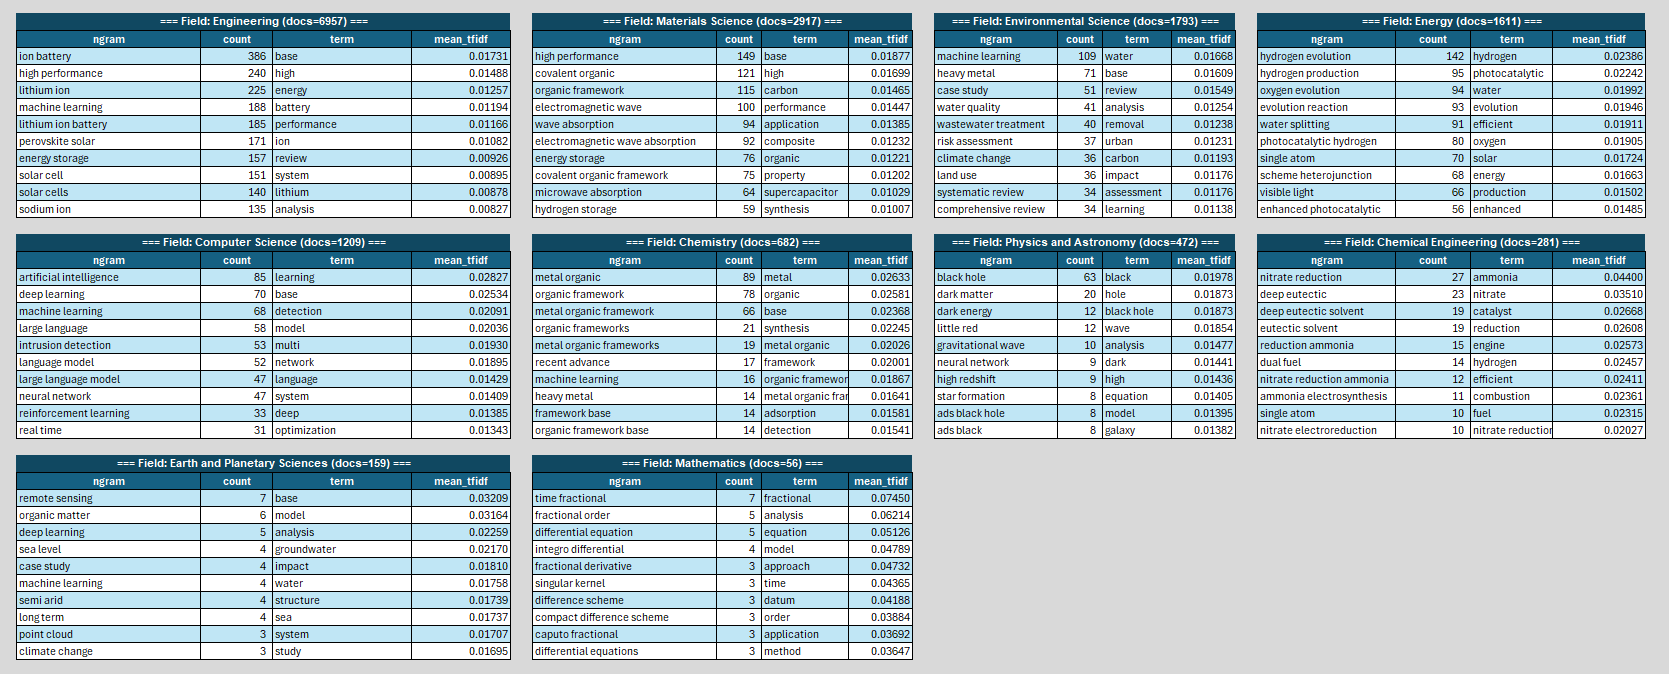

In [77]:
# Fields NLP Metrics
from IPython.display import Image, display
display(Image(filename="Fields NLP.png", width=1100, height=500))